In [1]:
import nltk
import warnings

warnings.filterwarnings('ignore')
nltk.download("all", quiet=True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


True

In [2]:
import random, os
import numpy as np
import torch

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(42)

In [3]:
import datasets
import pandas as pd
from ast import literal_eval
datasets.set_caching_enabled(False)

data_dir = '../input/vispamdataset-v2/preprocessed/'

def load_data(data_dir):
    train_df = pd.read_csv(data_dir + 'train.csv', converters={'categories': literal_eval})
    dev_df = pd.read_csv(data_dir + 'dev.csv', converters={'categories': literal_eval})
    test_df = pd.read_csv(data_dir + 'test.csv', converters={'categories': literal_eval})
    
    train_dataset = datasets.Dataset.from_dict(train_df)
    dev_dataset = datasets.Dataset.from_dict(dev_df)
    test_dataset = datasets.Dataset.from_dict(test_df)
    dataset_dict = datasets.DatasetDict({'train': train_dataset, 'dev': dev_dataset, 'test': test_dataset})
    
    return train_df, dev_df, test_df, dataset_dict

train_df, dev_df, test_df, vispam_datasets = load_data(data_dir)

In [4]:
import numpy as np
from nltk.tokenize import word_tokenize

def tokenizing(texts):
    max_len = 0
    tokenized_texts = []
    word2idx = {}
    
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1
    
    idx = 2
    for sent in texts:
        tokenized_sent = word_tokenize(sent)
        tokenized_texts.append(tokenized_sent)
        
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1
                
        max_len = max(max_len, len(tokenized_sent))
        
    return tokenized_texts, word2idx, max_len


def encoding(tokenized_texts, word2idx, max_len=100):
    input_ids = []
    for tokenized_sent in tokenized_texts:
        if len(tokenized_sent) > max_len:
            tokenized_sent = tokenized_sent[:max_len]
            
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))
        
        input_id = [word2idx.get(token, word2idx['<unk>']) for token in tokenized_sent]
        input_ids.append(input_id)
    
    return np.array(input_ids)

In [5]:
train_tokenized, word2idx, max_len = tokenizing(vispam_datasets['train']['clean_comment'])
print('Number of words:', len(word2idx))
print('Max length of sentence:', max_len)

Number of words: 15359
Max length of sentence: 215


In [6]:
def encode_mapping(examples):
    tokenized_texts = [word_tokenize(sent) for sent in examples['clean_comment']]
    input_ids = encoding(tokenized_texts, word2idx, max_len=100)
    
    return {'input_ids': input_ids}


encoded_datasets = vispam_datasets.map(encode_mapping, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-2])
encoded_datasets.set_format("torch")

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [7]:
import torch
import numpy as np
from tqdm import tqdm_notebook

def load_pretrained_vectors(word2idx, file_name):
    fin = open(file_name, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), d))
    embeddings[word2idx['<pad>']] = np.zeros((d,))
    
    count = 0
    for line in tqdm_notebook(fin):
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word2idx:
            count += 1
            embeddings[word2idx[word]] = np.array(tokens[1:], dtype=np.float32)
            
    print(f"There are {count} / {len(word2idx)} pretrained vectors found.")
    
    return embeddings


file_name = "../input/fasttext-pretrained-embeddings/cc.vi.300.vec"
embeddings = load_pretrained_vectors(word2idx, file_name)
embeddings = torch.tensor(embeddings)

0it [00:00, ?it/s]

There are 8584 / 15359 pretrained vectors found.


In [8]:
import os
import gc
import json
import numpy as np
from scipy import interpolate
from pathlib import Path
import torch
from torch import nn
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def evaluate(true_labels, predicts):
    test_accuracy = accuracy_score(true_labels, predicts)
    test_precision = precision_score(true_labels, predicts, average='macro')
    test_recall = recall_score(true_labels, predicts, average='macro')
    test_f1 = f1_score(true_labels, predicts, average='macro')
    test_cm = confusion_matrix(true_labels, predicts)

    print("Accuracy: {:.4f}".format(test_accuracy))
    print("Precision: {:.4f}".format(test_precision))
    print("Recall: {:.4f}".format(test_recall))
    print("F1-score: {:.4f}".format(test_f1))
    print("Confusion matrix:\n", test_cm)
    print(classification_report(true_labels, predicts, digits=4))
    
    return test_cm


def plotting_confusion_matrix(confusion_matrix, model_name, task):
    Path(model_name).mkdir(parents=True, exist_ok=True)
    
    if task == 1:
        labels = ['no-spam', 'spam']
        font_size = 30
    else:
        labels = ['no-spam', 'spam-1', 'spam-2', 'spam-3']
        font_size = 22
        
    plt.figure(dpi=100)
    df_cm = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    ax = sns.heatmap(df_cm, annot=True, cmap="Greys", fmt="g", cbar=True, annot_kws={"size": font_size})
    
    file_name = os.path.join(model_name, f"{model_name}_confusion_matrix_({task}).pdf")
    plt.savefig(file_name, dpi=300, bbox_inches='tight')
    plt.show()

In [9]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# TextCNN

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TextCNN(nn.Module):
    def __init__(self, task, kernel_sizes=[2, 3, 5], num_filters=32, drop=0.5, spatial_dropout=False, mode='static'):
        super(TextCNN, self).__init__()
        
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.vocab_size, self.embedding_dim = embeddings.shape
        self.kernel_sizes = kernel_sizes
        self.num_filters = num_filters
        self.drop = drop
        self.spatial_dropout = spatial_dropout
        self.mode = mode
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim, padding_idx=0)
        self.load_embeddings()
        
        if spatial_dropout:
            self.spatial_dropout1d = nn.Dropout2d(drop)
            
        self.conv = nn.ModuleList([nn.Conv1d(in_channels=self.embedding_dim, out_channels=num_filters, kernel_size=k, stride=1) for k in kernel_sizes])
        self.dropout = nn.Dropout(drop)
        self.fc = nn.Linear(len(kernel_sizes) * num_filters, self.num_classes)

    def forward(self, input_ids):
        batch_size, sequence_length = input_ids.shape
        h_embedding = self.embedding(input_ids).float()
        
        if self.spatial_dropout:
            h_embedding = h_embedding.permute(0, 2, 1)
            h_embedding = self.spatial_dropout1d(h_embedding)
            h_embedding = h_embedding.permute(0, 2, 1)
        
        x = h_embedding.permute(0, 2, 1)
        x = [F.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, kernel_size=c.shape[2]).squeeze(dim=2) for c in x]
        x = torch.cat(x, dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

    def load_embeddings(self):
        if 'static' in self.mode:
            self.embedding.weight.data.copy_(embeddings)
            if 'non' not in self.mode:
                self.embedding.weight.data.requires_grad = False
                print('Loaded pretrained embeddings, weights are not trainable.')
            else:
                self.embedding.weight.data.requires_grad = True
                print('Loaded pretrained embeddings, weights are trainable.')
        elif self.mode == 'rand':
            print('Randomly initialized embeddings are used.')
        else:
            raise ValueError('Unexpected value of mode. Please choose from static, non-static, rand.')
            

class BiLSTM(nn.Module):
    
    def __init__(self, task, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static'):
        super(BiLSTM, self).__init__()
        
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.vocab_size, self.embedding_dim = embeddings.shape
        self.hidden_size = hidden_size
        self.drop = drop
        self.spatial_dropout = spatial_dropout
        self.mode = mode
        
        if spatial_dropout:
            self.spatial_dropout1d = nn.Dropout2d(drop)
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim, padding_idx=0)
        self.load_embeddings()
        self.lstm = nn.LSTM(self.embedding_dim, hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_size*4 , 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drop)
        self.fc = nn.Linear(64, self.num_classes)
        
    def forward(self, input_ids):
        batch_size, sequence_length = input_ids.shape
        h_embedding = self.embedding(input_ids).float()
        
        if self.spatial_dropout:
            h_embedding = h_embedding.permute(0, 2, 1)
            h_embedding = self.spatial_dropout1d(h_embedding)
            h_embedding = h_embedding.permute(0, 2, 1)
        
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat((avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.fc(conc)
        
        return out
    
    def load_embeddings(self):
        if 'static' in self.mode:
            self.embedding.weight.data.copy_(embeddings)
            if 'non' not in self.mode:
                self.embedding.weight.data.requires_grad = False
                print('Loaded pretrained embeddings, weights are not trainable.')
            else:
                self.embedding.weight.data.requires_grad = True
                print('Loaded pretrained embeddings, weights are trainable.')
        elif self.mode == 'rand':
            print('Randomly initialized embeddings are used.')
        else:
            raise ValueError('Unexpected value of mode. Please choose from static, non-static, rand.')
            

class BiGRU(nn.Module):
    
    def __init__(self, task, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static'):
        super(BiGRU, self).__init__()
        
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.vocab_size, self.embedding_dim = embeddings.shape
        self.hidden_size = hidden_size
        self.drop = drop
        self.spatial_dropout = spatial_dropout
        self.mode = mode
        
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim, padding_idx=0)
        
        if spatial_dropout:
            self.spatial_dropout1d = nn.Dropout2d(drop)
        
        self.load_embeddings()
        self.gru = nn.GRU(self.embedding_dim, hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(hidden_size*4, 64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(drop)
        self.fc = nn.Linear(64, self.num_classes)
        
    def forward(self, input_ids):
        batch_size, sequence_length = input_ids.shape
        h_embedding = self.embedding(input_ids).float()
        
        if self.spatial_dropout:
            h_embedding = h_embedding.permute(0, 2, 1)
            h_embedding = self.spatial_dropout1d(h_embedding)
            h_embedding = h_embedding.permute(0, 2, 1)
            
        h_gru, _ = self.gru(h_embedding)
        avg_pool = torch.mean(h_gru, 1)
        max_pool, _ = torch.max(h_gru, 1)
        conc = torch.cat((avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.fc(conc)
        
        return out
    
    def load_embeddings(self):
        if 'static' in self.mode:
            self.embedding.weight.data.copy_(embeddings)
            if 'non' not in self.mode:
                self.embedding.weight.data.requires_grad = False
                print('Loaded pretrained embeddings, weights are not trainable.')
            else:
                self.embedding.weight.data.requires_grad = True
                print('Loaded pretrained embeddings, weights are trainable.')
        elif self.mode == 'rand':
            print('Randomly initialized embeddings are used.')
        else:
            raise ValueError('Unexpected value of mode. Please choose from static, non-static, rand.')
            

def test(model, dataloader, task):
    model.eval()
    
    predicts = []
    predict_probs = []
    true_labels = []
    
    label_column = 'label' if task == 1 else 'spam_label'
    
    for data in tqdm(dataloader):
        input_ids = data['input_ids'].to(device)
        labels = data[label_column].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids)
         
        pred = torch.max(outputs, dim=1)[1]
        predicts.extend(pred.cpu().data.numpy())
        predict_probs.extend(outputs.cpu().data.numpy())
        true_labels.extend(labels.cpu().data.numpy())
        
    return true_labels, predicts

In [11]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=256)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=256)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=256)

Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8226
Precision: 0.7727
Recall: 0.7709
F1-score: 0.7718
Confusion matrix:
 [[2565  346]
 [ 357  695]]
              precision    recall  f1-score   support

           0     0.8778    0.8811    0.8795      2911
           1     0.6676    0.6606    0.6641      1052

    accuracy                         0.8226      3963
   macro avg     0.7727    0.7709    0.7718      3963
weighted avg     0.8220    0.8226    0.8223      3963



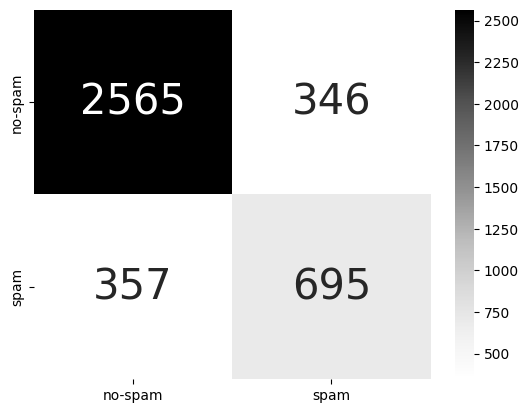

In [12]:
import os
import torch

model_name = "TextCNN"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(1).pth"
model = TextCNN(task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=1)

In [13]:
import os
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(1).csv'), index=False)
wrong_df = predict_df[predict_df.label != predict_df.predict]
sorted_df = wrong_df.sort_values(['label', 'predict'], ascending=[False, False])
sorted_df

,comment,category,description,label,predict
8,Kakaa ba nằm bên trái thì e bé nhét qua bên tr...,Thời Trang,"Quần lót nam thun lạnh nhật bản, quần sịp đúc ...",1,0
25,"Hàng đẹp . giao rất ok , ủng hộ ạ \r\nHàng đẹp...",Sách,Thời gian giao hàng dự kiến cho sản phẩm này l...,1,0
34,Giao hàng nhanh. Hình ảnh vs video mang tính c...,Nhà Cửa - Đời Sống,5 lưu ý trước khi đặt hàng: 1 - Miễn phí vận c...,1,0
38,Mua bnh cái túi đựng bài cũng k bao h là đủ ấy...,Nhà Cửa - Đời Sống,Túi Nhung Đưng Tarot Tiền Cao Cấp Túi vải nhun...,1,0
44,Không chụp ảnh được sản phẩm nên mình lấy tạm ...,Máy Ảnh,Đặc tính ưu Việt của Camera Yoosee Tiếng Việt ...,1,0
...,...,...,...,...,...
3913,Siêu tooooo\r\nGiao hàng siêu nhanh\r\nHàng sử...,Điện Tử,GIAO HÀNG VÀ LẮP ĐẶT CÙNG LÚCGiá sản...,0,1
3924,"Dùng trên MacOS nét lắm anh em nhé, mọi người ...",Điện Thoai - Máy Tính,Xem thêm để bạn có thể làm nhiều hơ...,0,1
3937,"Giao hàng nhanh, đóng gói cẩn thận. Hàng chất ...",Thời Trang,GIỚI THIỆU SẢN PHẨM : Tất nam nữ cổ cao trắng ...,0,1
3945,Hàng tới h là ngon,Điện Thoai - Máy Tính,Màn hình Liquid Retina iPad Air mới sở h...,0,1


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7858
Precision: 0.5841
Recall: 0.6585
F1-score: 0.6064
Confusion matrix:
 [[2458   46  278  129]
 [  17   29    4    4]
 [ 100    1  192   16]
 [ 203   11   40  435]]
              precision    recall  f1-score   support

           0     0.8848    0.8444    0.8641      2911
           1     0.3333    0.5370    0.4113        54
           2     0.3735    0.6214    0.4666       309
           3     0.7449    0.6313    0.6834       689

    accuracy                         0.7858      3963
   macro avg     0.5841    0.6585    0.6064      3963
weighted avg     0.8131    0.7858    0.7955      3963



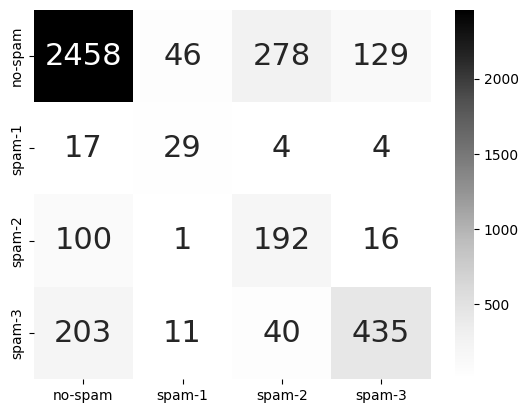

In [14]:
import os
import torch

model_name = "TextCNN"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(2).pth"
model = TextCNN(task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=2)

In [15]:
import os
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'spam_label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(2).csv'), index=False)
wrong_df = predict_df[predict_df.spam_label != predict_df.predict]
sorted_df = wrong_df.sort_values(['spam_label', 'predict'], ascending=[False, False])
sorted_df

,comment,category,description,spam_label,predict
59,Hàng ạ gởi bài vào vào đây ạ gửi gửi vào túi n...,Thời Trang,Thời gian giao hàng dự kiến cho sản phẩm này l...,3,2
90,Nói chung là hài lòng nhe quý dị 👍,Khác,ĐẶC ĐIỂM NỔI BẬT ✓ Sợi bún dai ngon...,3,2
285,"Giao chậm nhg nhanh như cơn gió, ship uy tín n...",Khác,"HƯỚNG DẪN MUA THẺ Viettel 100k ,QUÝ KHÁCH VUI ...",3,2
536,"Giao hàng hơi lâu, đóng gói được, nói chung cũ...",Nhà Cửa - Đời Sống,Sản phẩm khăn giấy ướt được sản xuất từ nguyên...,3,2
568,"Tốt , hàng như hình, ship nhanh ạ hsjddjdkaksh...",Sắc Đẹp,✅ SẴN HÀNG ✅ Tặng quà ngẫu nhiên cho mỗi đơn h...,3,2
...,...,...,...,...,...
3351,Hai long voi san pham,Đồ Chơi,Lưu ý: Bao bì thay đổi tuy theo từng đo...,0,1
3821,Shop phục vụ rất tốt. Rất đáng tiền. Thời gian...,Thời Trang,Thời gian giao hàng dự kiến cho sản phẩm này l...,0,1
3829,Giao hàng nhanh balo đỉnh luôn với giá thế này...,Thời Trang,"Balo Laptop nam nữ Thời Trang chống trộm, chốn...",0,1
3867,"Cáp sàng faceid uy tín giao hàng nhanh chóng ,...",Điện Thoai - Máy Tính,* Giấy in nhiệt của Shoptida chuyên dụng cho ...,0,1


# BiLSTM

Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8294
Precision: 0.7907
Recall: 0.7494
F1-score: 0.7655
Confusion matrix:
 [[2678  233]
 [ 443  609]]
              precision    recall  f1-score   support

           0     0.8581    0.9200    0.8879      2911
           1     0.7233    0.5789    0.6431      1052

    accuracy                         0.8294      3963
   macro avg     0.7907    0.7494    0.7655      3963
weighted avg     0.8223    0.8294    0.8229      3963



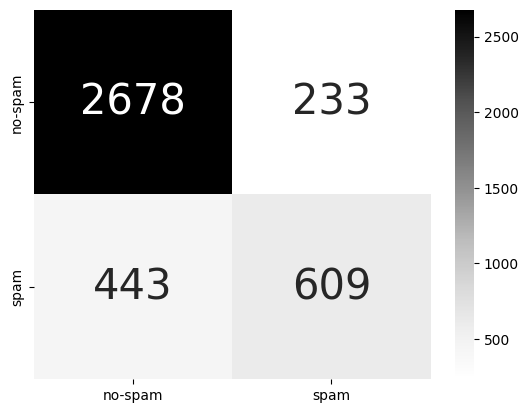

In [16]:
import os
import torch

model_name = "BiLSTM"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(1).pth"
model = BiLSTM(task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=1)

In [17]:
import os
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(1).csv'), index=False)
wrong_df = predict_df[predict_df.label != predict_df.predict]
sorted_df = wrong_df.sort_values(['label', 'predict'], ascending=[False, False])
sorted_df

,comment,category,description,label,predict
8,Kakaa ba nằm bên trái thì e bé nhét qua bên tr...,Thời Trang,"Quần lót nam thun lạnh nhật bản, quần sịp đúc ...",1,0
25,"Hàng đẹp . giao rất ok , ủng hộ ạ \r\nHàng đẹp...",Sách,Thời gian giao hàng dự kiến cho sản phẩm này l...,1,0
26,Cần kích cá liên hệ zalo 0914006498,Điện Tử,TÍNH NĂNG SẢN PHẨM - Opto là một linh kiện qua...,1,0
34,Giao hàng nhanh. Hình ảnh vs video mang tính c...,Nhà Cửa - Đời Sống,5 lưu ý trước khi đặt hàng: 1 - Miễn phí vận c...,1,0
38,Mua bnh cái túi đựng bài cũng k bao h là đủ ấy...,Nhà Cửa - Đời Sống,Túi Nhung Đưng Tarot Tiền Cao Cấp Túi vải nhun...,1,0
...,...,...,...,...,...
3895,Đợt này giao hàng hơi lâu. Đã mua của shop nhi...,Thời Trang,Quần sơ sinh bình sữa được làm từ chất liệu co...,0,1
3896,Tạm thời là dùng ổn,Điện Tử,Thiết kế thân thiện Logitech B100 sử ...,0,1
3913,Siêu tooooo\r\nGiao hàng siêu nhanh\r\nHàng sử...,Điện Tử,GIAO HÀNG VÀ LẮP ĐẶT CÙNG LÚCGiá sản...,0,1
3940,"Trước giờ toàn ăn vị cay, nay mua thử lẩu thập...",Khác,🌶️Gia Vị Lẩu Haidilao (Hải Đế Lao) Chắc hẳn ai...,0,1


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7837
Precision: 0.6007
Recall: 0.6600
F1-score: 0.6104
Confusion matrix:
 [[2459   35  322   95]
 [  18   28    6    2]
 [  88    2  212    7]
 [ 222   12   48  407]]
              precision    recall  f1-score   support

           0     0.8823    0.8447    0.8631      2911
           1     0.3636    0.5185    0.4275        54
           2     0.3605    0.6861    0.4727       309
           3     0.7965    0.5907    0.6783       689

    accuracy                         0.7837      3963
   macro avg     0.6007    0.6600    0.6104      3963
weighted avg     0.8196    0.7837    0.7946      3963



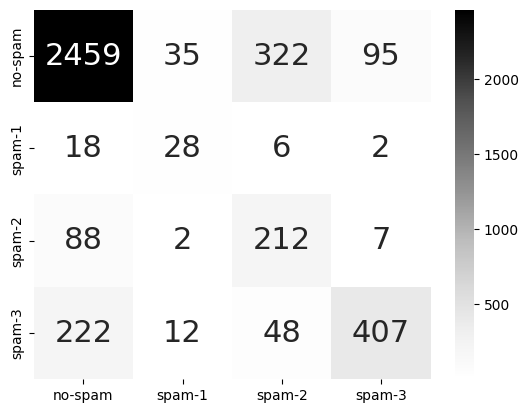

In [18]:
import os
import torch

model_name = "BiLSTM"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(2).pth"
model = BiLSTM(task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=2)

In [19]:
import os
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'spam_label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(2).csv'), index=False)
wrong_df = predict_df[predict_df.spam_label != predict_df.predict]
sorted_df = wrong_df.sort_values(['spam_label', 'predict'], ascending=[False, False])
sorted_df

,comment,category,description,spam_label,predict
53,hàng OK rồi em vẫn đang tiếp tục vào vai một c...,Khác,Dầu Ăn Thượng Hạng Nhãn Hiệu Neptune...,3,2
226,Giao hàng nhanh. Sản phẩm như hình. Sẽ ủng hộ ...,Thể Thao,Thông số sản phẩm ✔️Kích thước: 80-130cm/ 60-1...,3,2
285,"Giao chậm nhg nhanh như cơn gió, ship uy tín n...",Khác,"HƯỚNG DẪN MUA THẺ Viettel 100k ,QUÝ KHÁCH VUI ...",3,2
352,Mua cho mẹ. Hy vọng mẹ sẽ học được ❤️‍🔥❤️‍🔥❤️‍...,Sách,Thương hiệu: Nguyễn Văn Hiệp Nhà phát hành: Cô...,3,2
536,"Giao hàng hơi lâu, đóng gói được, nói chung cũ...",Nhà Cửa - Đời Sống,Sản phẩm khăn giấy ướt được sản xuất từ nguyên...,3,2
...,...,...,...,...,...
3092,"Shop vẫn cứ là dễ thương lắm\r\nHỗ trợ tốt, sả...",Thời Trang,DEAL NGẪU NHIÊN KHÔNG LỰA MẪU / Khách lựa mẫu ...,0,1
3267,"Sản phẩm tuyệt vời chất lượng tốt, giao hàng n...",Điện Thoai - Máy Tính,Tai Nghe Bluetooth Không Dây i12 TWS 5.0 Âm T...,0,1
3829,Giao hàng nhanh balo đỉnh luôn với giá thế này...,Thời Trang,"Balo Laptop nam nữ Thời Trang chống trộm, chốn...",0,1
3879,"Chất lượng sản phẩm tuyệt vời, giao hàng nhanh...",Sách,Thời gian giao hàng dự kiến cho sản phẩm này ...,0,1


# BiGRU

Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8312
Precision: 0.7856
Recall: 0.7725
F1-score: 0.7786
Confusion matrix:
 [[2613  298]
 [ 371  681]]
              precision    recall  f1-score   support

           0     0.8757    0.8976    0.8865      2911
           1     0.6956    0.6473    0.6706      1052

    accuracy                         0.8312      3963
   macro avg     0.7856    0.7725    0.7786      3963
weighted avg     0.8279    0.8312    0.8292      3963



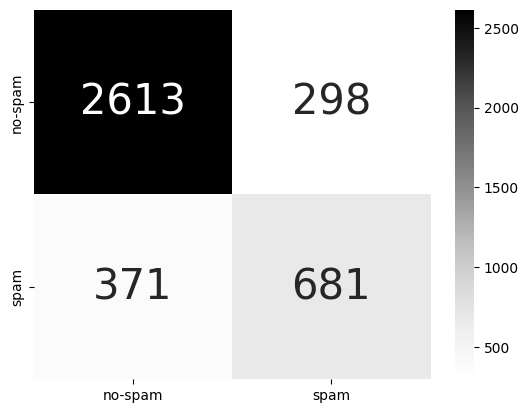

In [20]:
import os
import torch

model_name = "BiGRU"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(1).pth"
model = BiGRU(task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=1)

In [21]:
import os
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(1).csv'), index=False)
wrong_df = predict_df[predict_df.label != predict_df.predict]
sorted_df = wrong_df.sort_values(['label', 'predict'], ascending=[False, False])
sorted_df

,comment,category,description,label,predict
8,Kakaa ba nằm bên trái thì e bé nhét qua bên tr...,Thời Trang,"Quần lót nam thun lạnh nhật bản, quần sịp đúc ...",1,0
25,"Hàng đẹp . giao rất ok , ủng hộ ạ \r\nHàng đẹp...",Sách,Thời gian giao hàng dự kiến cho sản phẩm này l...,1,0
26,Cần kích cá liên hệ zalo 0914006498,Điện Tử,TÍNH NĂNG SẢN PHẨM - Opto là một linh kiện qua...,1,0
38,Mua bnh cái túi đựng bài cũng k bao h là đủ ấy...,Nhà Cửa - Đời Sống,Túi Nhung Đưng Tarot Tiền Cao Cấp Túi vải nhun...,1,0
44,Không chụp ảnh được sản phẩm nên mình lấy tạm ...,Máy Ảnh,Đặc tính ưu Việt của Camera Yoosee Tiếng Việt ...,1,0
...,...,...,...,...,...
3913,Siêu tooooo\r\nGiao hàng siêu nhanh\r\nHàng sử...,Điện Tử,GIAO HÀNG VÀ LẮP ĐẶT CÙNG LÚCGiá sản...,0,1
3918,Giao hàng nhanh đã nhận được hàng. Khá vừa ý. ...,Thể Thao,THÔNG TIN SẢN PHẨM - Sản phẩm: Tất cổ ngắn - C...,0,1
3937,"Giao hàng nhanh, đóng gói cẩn thận. Hàng chất ...",Thời Trang,GIỚI THIỆU SẢN PHẨM : Tất nam nữ cổ cao trắng ...,0,1
3943,quay lại mua lần thứ 4 .cứ mỗi lần lại ...,Nhà Cửa - Đời Sống,Ngủ ngon và sâu hơn với sự nâng đỡ ...,0,1


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.7744
Precision: 0.5704
Recall: 0.6909
F1-score: 0.6095
Confusion matrix:
 [[2311   45  355  200]
 [  15   29    5    5]
 [  73    2  210   24]
 [ 128   14   28  519]]
              precision    recall  f1-score   support

           0     0.9145    0.7939    0.8499      2911
           1     0.3222    0.5370    0.4028        54
           2     0.3512    0.6796    0.4631       309
           3     0.6939    0.7533    0.7223       689

    accuracy                         0.7744      3963
   macro avg     0.5704    0.6909    0.6095      3963
weighted avg     0.8242    0.7744    0.7915      3963



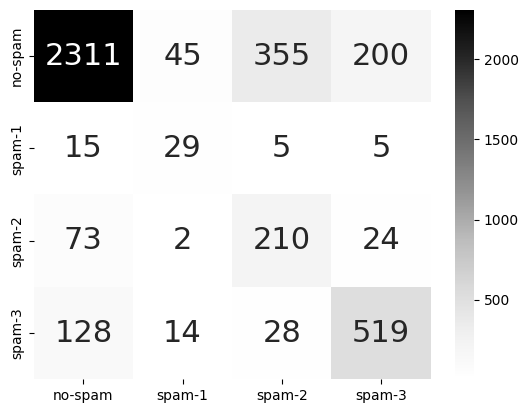

In [22]:
import os
import torch

model_name = "BiGRU"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(2).pth"
model = BiGRU(task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=2)

In [23]:
import os
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'spam_label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(2).csv'), index=False)
wrong_df = predict_df[predict_df.spam_label != predict_df.predict]
sorted_df = wrong_df.sort_values(['spam_label', 'predict'], ascending=[False, False])
sorted_df

,comment,category,description,spam_label,predict
285,"Giao chậm nhg nhanh như cơn gió, ship uy tín n...",Khác,"HƯỚNG DẪN MUA THẺ Viettel 100k ,QUÝ KHÁCH VUI ...",3,2
536,"Giao hàng hơi lâu, đóng gói được, nói chung cũ...",Nhà Cửa - Đời Sống,Sản phẩm khăn giấy ướt được sản xuất từ nguyên...,3,2
586,"shop giao hàng nhanh, chu đáo, cẩn thận rất hà...",Đồ Chơi,"Máy Tạo Tiếng Ồn Trắng Giúp bé ngủ ngon, sâu g...",3,2
628,"Giao hàng nhanh chóng,bbdbfbfjfjhfbfhfhhfjfhfh...",Nhà Cửa - Đời Sống,"Cam kết: - Hàng chuẩn công ty, dày đẹp - Không...",3,2
700,Cảm ơn b đã tin tưởng và ủng hộ kín...,Khác,[E-voucher] Mã mua hàng Shopee (trừ Nạp Thẻ...,3,2
...,...,...,...,...,...
3433,Sản phẩm mỏng hơn dây mình đã mua chỗ khác như...,Điện Tử,dây cấp (dây to) và dây thải (dây nhỏ)dùng cho...,0,1
3821,Shop phục vụ rất tốt. Rất đáng tiền. Thời gian...,Thời Trang,Thời gian giao hàng dự kiến cho sản phẩm này l...,0,1
3829,Giao hàng nhanh balo đỉnh luôn với giá thế này...,Thời Trang,"Balo Laptop nam nữ Thời Trang chống trộm, chốn...",0,1
3879,"Chất lượng sản phẩm tuyệt vời, giao hàng nhanh...",Sách,Thời gian giao hàng dự kiến cho sản phẩm này ...,0,1


In [24]:
import numpy as np
import torch
import torch.nn.functional as F

class_names = ['no-spam', 'spam']
spam_class_names = ['no-spam', 'spam-1', 'spam-2', 'spam-3']

def encode_text(text, word2idx, max_len=100):
    tokenized_text = word_tokenize(text)
    if len(tokenized_text) > max_len:
        tokenized_text = tokenized_text[:max_len]
    tokenized_text += ['<pad>'] * (max_len - len(tokenized_text))
    input_id = [word2idx.get(token, word2idx['<unk>']) for token in tokenized_text]
    return np.array(input_id)

def inference(model, text, word2idx, task=1):
    model.eval()
    
    input_ids = encode_text(text, word2idx, max_len=100)
    input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_ids)
    predict_label = torch.argmax(outputs, dim=1)[0]
    probability = F.softmax(outputs, dim=1)[0][predict_label]
    
    print(f'Sentence: {text}')
    print(f'Predict: {class_names[predict_label] if task == 1 else spam_class_names[predict_label]}')
    print(f'Probability: {round(probability.cpu().item(), 4)}')

In [25]:
task = 2
model_name = "TextCNN"

if model_name == "TextCNN":
    model = TextCNN(task).to(device)
elif model_name == "BiLSTM":
    model = BiLSTM(task).to(device)
else:
    model = BiGRU(task).to(device)
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(2).pth"
model.load_state_dict(torch.load(model_path))

comment = 'Chưa dùng nên chưa biết thế nào nữa'
inference(model, comment, word2idx, task)

Loaded pretrained embeddings, weights are not trainable.
Sentence: Chưa dùng nên chưa biết thế nào nữa
Predict: spam-2
Probability: 0.9731


# PhoBERT

In [26]:
from torch import nn
from transformers import AutoModel, BertModel

class ViSpam_Classifier(nn.Module):
    
    def __init__(self, model_name, task, freeze_bert=False, drop=0.3):
        super(ViSpam_Classifier, self).__init__()
        
        assert model_name in ['PhoBERT', 'BERT4News', 'ViBERT']
        
        self.model_name = model_name
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        
        if model_name == 'PhoBERT':
            self.bert = AutoModel.from_pretrained('vinai/phobert-base')
        elif model_name == 'BERT4News':
            self.bert = BertModel.from_pretrained('NlpHUST/vibert4news-base-cased')
        else:
            self.bert = AutoModel.from_pretrained('FPTAI/vibert-base-cased')
            
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
        self.drop = nn.Dropout(drop)
        self.fc = nn.Linear(self.bert.config.hidden_size, self.num_classes)
        # nn.init.normal_(self.fc.weight, std=0.02)
        # nn.init.normal_(self.fc.bias, 0)
        
    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False
        )
        x = self.drop(output)
        x = self.fc(x)
        return x
    
    
def test(model, dataloader, task):
    model.eval()
    predicts = []
    predict_probs = []
    true_labels = []
    
    label_column = 'label' if task == 1 else 'spam_label'

    for data in tqdm(dataloader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        labels = data[label_column].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
        pred = torch.max(outputs, dim=1)[1]
        predicts.extend(pred.cpu().data.numpy())
        predict_probs.extend(outputs.cpu().data.numpy())
        true_labels.extend(labels.cpu().data.numpy())
        
    return true_labels, predicts

In [27]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

def encode_data(examples):
    return tokenizer(examples["clean_tokenized_comment"], padding="max_length", max_length=100, truncation=True, add_special_tokens=True)

encoded_datasets = vispam_datasets.map(encode_data, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-2])
encoded_datasets.set_format("torch")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [28]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=16)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=16)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=16)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8923
Precision: 0.8740
Recall: 0.8417
F1-score: 0.8558
Confusion matrix:
 [[2764  147]
 [ 280  772]]
              precision    recall  f1-score   support

           0     0.9080    0.9495    0.9283      2911
           1     0.8400    0.7338    0.7834      1052

    accuracy                         0.8923      3963
   macro avg     0.8740    0.8417    0.8558      3963
weighted avg     0.8900    0.8923    0.8898      3963



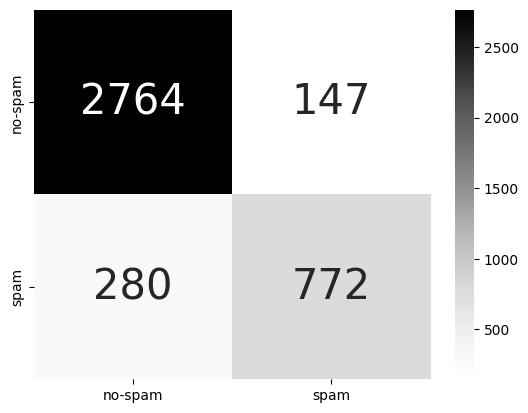

In [29]:
import os
import torch

model_name = "PhoBERT"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(1).pth"
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=1)

In [30]:
import os
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(1).csv'), index=False)
wrong_df = predict_df[predict_df.label != predict_df.predict]
sorted_df = wrong_df.sort_values(['label', 'predict'], ascending=[False, False])
sorted_df

,comment,category,description,label,predict
8,Kakaa ba nằm bên trái thì e bé nhét qua bên tr...,Thời Trang,"Quần lót nam thun lạnh nhật bản, quần sịp đúc ...",1,0
25,"Hàng đẹp . giao rất ok , ủng hộ ạ \r\nHàng đẹp...",Sách,Thời gian giao hàng dự kiến cho sản phẩm này l...,1,0
38,Mua bnh cái túi đựng bài cũng k bao h là đủ ấy...,Nhà Cửa - Đời Sống,Túi Nhung Đưng Tarot Tiền Cao Cấp Túi vải nhun...,1,0
44,Không chụp ảnh được sản phẩm nên mình lấy tạm ...,Máy Ảnh,Đặc tính ưu Việt của Camera Yoosee Tiếng Việt ...,1,0
53,hàng OK rồi em vẫn đang tiếp tục vào vai một c...,Khác,Dầu Ăn Thượng Hạng Nhãn Hiệu Neptune...,1,0
...,...,...,...,...,...
3840,Dây y hình\r\nĐóng gói cẢn thận\r\nSẽ ủng hộ s...,Thể Thao,👉SPORT 247 cam kết giá bán rẻ nhất shopee ở đâ...,0,1
3879,"Chất lượng sản phẩm tuyệt vời, giao hàng nhanh...",Sách,Thời gian giao hàng dự kiến cho sản phẩm này ...,0,1
3895,Đợt này giao hàng hơi lâu. Đã mua của shop nhi...,Thời Trang,Quần sơ sinh bình sữa được làm từ chất liệu co...,0,1
3896,Tạm thời là dùng ổn,Điện Tử,Thiết kế thân thiện Logitech B100 sử ...,0,1


Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8779
Precision: 0.7185
Recall: 0.7142
F1-score: 0.7156
Confusion matrix:
 [[2700   21  105   85]
 [  16   31    0    7]
 [ 147    0  151   11]
 [  72    5   15  597]]
              precision    recall  f1-score   support

           0     0.9199    0.9275    0.9237      2911
           1     0.5439    0.5741    0.5586        54
           2     0.5572    0.4887    0.5207       309
           3     0.8529    0.8665    0.8596       689

    accuracy                         0.8779      3963
   macro avg     0.7185    0.7142    0.7156      3963
weighted avg     0.8749    0.8779    0.8762      3963



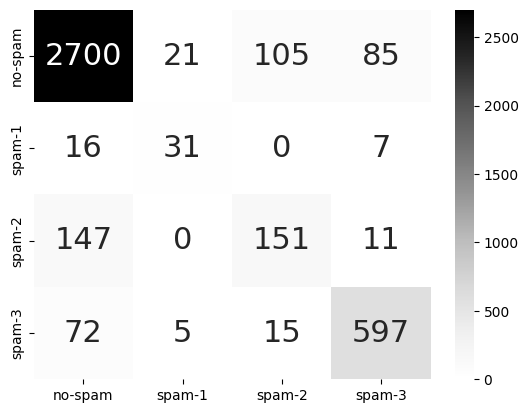

In [31]:
import os
import torch

model_name = "PhoBERT"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(2).pth"
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=2)

In [32]:
import os
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'spam_label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(2).csv'), index=False)
wrong_df = predict_df[predict_df.spam_label != predict_df.predict]
sorted_df = wrong_df.sort_values(['spam_label', 'predict'], ascending=[False, False])
sorted_df

,comment,category,description,spam_label,predict
766,giao hàng,Khác,LƯU Ý: Bao Bì Sản phẩm có thể thay đo...,3,2
805,Shop kết nối sao vậy shop,Máy Ảnh,"* Sản phẩm có 3 thuộc tính lựa chọn,...",3,2
1005,Đặt 8 cửa shop giao có 5 cửa nt shop k phản hồ...,Thể Thao,Giới thiệu sản phẩm Lưới bát quái đánh bắt cá ...,3,2
1477,Dán tem lại cho chăc!,Điện Thoai - Máy Tính,Giới thiệu sản phẩm USB Sandisk Ultra L...,3,2
1509,Vui lòng đăng nhập Shopee để xác nhận bạn đã n...,Thể Thao,DƯƠNG SPORT tự hào là đơn vị cung cấp phụ kiện...,3,2
...,...,...,...,...,...
2826,"Chất lượng sản phẩm tuyệt vời , giao hàng nhan...",Phương Tiện,Chất Liệu : Titan Đặc Tính : Là Hợp Kim Cứng H...,0,1
2909,"Chất lượng sản phẩm tuyệt vời, má",Điện Tử,"Thiết kế hiện đại, tinh tế Máy lạnh...",0,1
3267,"Sản phẩm tuyệt vời chất lượng tốt, giao hàng n...",Điện Thoai - Máy Tính,Tai Nghe Bluetooth Không Dây i12 TWS 5.0 Âm T...,0,1
3446,"Giao hàng nhanh , chất lượng sản phẩm rất tuyệ...",Điện Thoai - Máy Tính,*Máy in đơn hàng TMĐT SP46 của Shoptida - Nha...,0,1


# BERT4News

In [33]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("NlpHUST/vibert4news-base-cased")

def encode_data(examples):
    return tokenizer(examples["clean_comment"], padding="max_length", max_length=100, truncation=True, add_special_tokens=True)

encoded_datasets = vispam_datasets.map(encode_data, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-2])
encoded_datasets.set_format("torch")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'BertTokenizer'.


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [34]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=16)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=16)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=16)

Some weights of the model checkpoint at NlpHUST/vibert4news-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8849
Precision: 0.8535
Recall: 0.8500
F1-score: 0.8518
Confusion matrix:
 [[2691  220]
 [ 236  816]]
              precision    recall  f1-score   support

           0     0.9194    0.9244    0.9219      2911
           1     0.7876    0.7757    0.7816      1052

    accuracy                         0.8849      3963
   macro avg     0.8535    0.8500    0.8518      3963
weighted avg     0.8844    0.8849    0.8847      3963



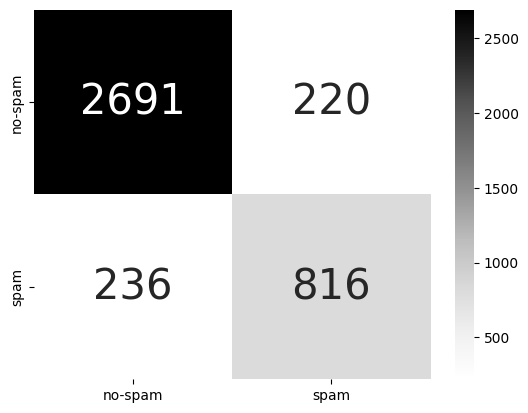

In [35]:
import os
import torch

model_name = "BERT4News"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(1).pth"
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=1)

In [36]:
import os
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(1).csv'), index=False)
wrong_df = predict_df[predict_df.label != predict_df.predict]
sorted_df = wrong_df.sort_values(['label', 'predict'], ascending=[False, False])
sorted_df

,comment,category,description,label,predict
12,❤❤Khuyến mai gói v120❤️❤️\r\nGiá lẻ 120k/ thán...,Nhà Cửa - Đời Sống,"""""""""""""""1/ NƯỚC GIẶT OMO MATIC CHO QUẦN ÁO BÉ Y...",1,0
25,"Hàng đẹp . giao rất ok , ủng hộ ạ \r\nHàng đẹp...",Sách,Thời gian giao hàng dự kiến cho sản phẩm này l...,1,0
38,Mua bnh cái túi đựng bài cũng k bao h là đủ ấy...,Nhà Cửa - Đời Sống,Túi Nhung Đưng Tarot Tiền Cao Cấp Túi vải nhun...,1,0
44,Không chụp ảnh được sản phẩm nên mình lấy tạm ...,Máy Ảnh,Đặc tính ưu Việt của Camera Yoosee Tiếng Việt ...,1,0
59,Hàng ạ gởi bài vào vào đây ạ gửi gửi vào túi n...,Thời Trang,Thời gian giao hàng dự kiến cho sản phẩm này l...,1,0
...,...,...,...,...,...
3862,Shop gói hàng cẩn thận nên đĩa không bị gãy ha...,Điện Thoai - Máy Tính,SẢN PHẨM BAO GỒM 1 ĐĨA VÀ 1 BAO ĐỰNG ĐĨA . NẾU...,0,1
3873,"Hàng chẮc chắn, giao hàng nhanh.",Điện Tử,1./ thông số kỹ thuật: Bộ nhớ trong 32GB Hỗ tr...,0,1
3879,"Chất lượng sản phẩm tuyệt vời, giao hàng nhanh...",Sách,Thời gian giao hàng dự kiến cho sản phẩm này ...,0,1
3896,Tạm thời là dùng ổn,Điện Tử,Thiết kế thân thiện Logitech B100 sử ...,0,1


Some weights of the model checkpoint at NlpHUST/vibert4news-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/248 [00:00<?, ?it/s]

Accuracy: 0.8824
Precision: 0.7616
Recall: 0.6971
F1-score: 0.7256
Confusion matrix:
 [[2769   13   75   54]
 [  16   31    1    6]
 [ 161    0  141    7]
 [ 112    4   17  556]]
              precision    recall  f1-score   support

           0     0.9055    0.9512    0.9278      2911
           1     0.6458    0.5741    0.6078        54
           2     0.6026    0.4563    0.5193       309
           3     0.8925    0.8070    0.8476       689

    accuracy                         0.8824      3963
   macro avg     0.7616    0.6971    0.7256      3963
weighted avg     0.8761    0.8824    0.8776      3963



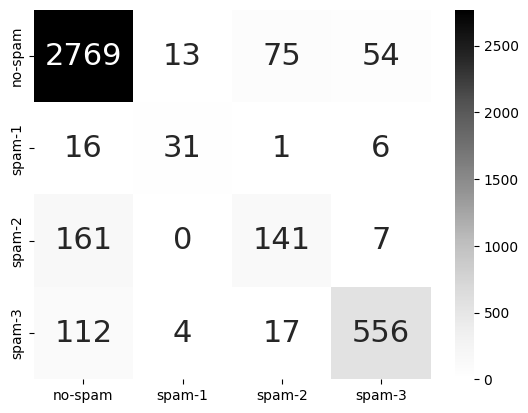

In [37]:
import os
import torch

model_name = "BERT4News"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(2).pth"
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=2)

In [38]:
import os
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'spam_label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(2).csv'), index=False)
wrong_df = predict_df[predict_df.spam_label != predict_df.predict]
sorted_df = wrong_df.sort_values(['spam_label', 'predict'], ascending=[False, False])
sorted_df

,comment,category,description,spam_label,predict
59,Hàng ạ gởi bài vào vào đây ạ gửi gửi vào túi n...,Thời Trang,Thời gian giao hàng dự kiến cho sản phẩm này l...,3,2
440,Được tặng kẹp tóc xinh lắm nha,Sắc Đẹp,Son Ofélia x Miracle Apo Flawsome Glow Lip la...,3,2
700,Cảm ơn b đã tin tưởng và ủng hộ kín...,Khác,[E-voucher] Mã mua hàng Shopee (trừ Nạp Thẻ...,3,2
766,giao hàng,Khác,LƯU Ý: Bao Bì Sản phẩm có thể thay đo...,3,2
1477,Dán tem lại cho chăc!,Điện Thoai - Máy Tính,Giới thiệu sản phẩm USB Sandisk Ultra L...,3,2
...,...,...,...,...,...
1660,"chất lượng sản phẩm tuyệt vời, đóng gói sản ph...",Nhà Cửa - Đời Sống,THÔNG SỐ KĨ THUẬT - Điện áp: 12VDC. - Chất liệ...,0,1
2732,Chất lượng sản phẩm tuyệt vời. Đóng gói sản ph...,Thời Trang,Túi Zip Đựng Đồ Trong Suốt Nhiều Size Hoạ Tiết...,0,1
2826,"Chất lượng sản phẩm tuyệt vời , giao hàng nhan...",Phương Tiện,Chất Liệu : Titan Đặc Tính : Là Hợp Kim Cứng H...,0,1
3829,Giao hàng nhanh balo đỉnh luôn với giá thế này...,Thời Trang,"Balo Laptop nam nữ Thời Trang chống trộm, chốn...",0,1


In [39]:
import torch
from transformers import AutoTokenizer, BertTokenizer

def inference(model, text, tokenizer, task=1):
    model.eval()
    
    if model.model_name == "PhoBERT":
        tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
    else:
        tokenizer = BertTokenizer.from_pretrained("NlpHUST/vibert4news-base-cased")
    
    data = tokenizer(text, padding="max_length", max_length=100, truncation=True, add_special_tokens=True)
    input_ids = torch.tensor(data['input_ids']).unsqueeze(0).to(device)
    attention_mask = torch.tensor(data['attention_mask']).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
    predict_label = torch.argmax(outputs, dim=1)[0]
    probability = F.softmax(outputs, dim=1)[0][predict_label]
    
    print(f'Sentence: {text}')
    print(f'Predict: {class_names[predict_label] if task == 1 else spam_class_names[predict_label]}')
    print(f'Probability: {round(probability.cpu().item(), 4)}')

In [40]:
task = 2
model_name = "PhoBERT"

model = ViSpam_Classifier(model_name, task).to(device)
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_({task}).pth"
model.load_state_dict(torch.load(model_path))

comment = 'hàng mới nhận thôi, mình chưa biết dùng có tốt không nữa, lần sau sẽ đánh giá'
inference(model, comment, tokenizer, task)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Sentence: hàng mới nhận thôi, mình chưa biết dùng có tốt không nữa, lần sau sẽ đánh giá
Predict: spam-2
Probability: 0.9109


# TextCNN + linear basis cust

In [41]:
category2idx = {
    'Điện Thoai - Máy Tính': 0,
    'Khác': 1,
    'Máy Ảnh': 2,
    'Nhà Cửa - Đời Sống': 3,
    'Điện Tử': 4,
    'Thời Trang': 5,
    'Sắc Đẹp': 6,
    'Sách': 7,
    'Phương Tiện': 8,
    'Giày Dép': 9, 
    'Thể Thao': 10,
    'Đồ Chơi': 11,
}
num_categories = len(category2idx)
print("Number of categories:", num_categories)

Number of categories: 12


In [42]:
def encode_mapping(examples):
    tokenized_texts = [word_tokenize(sent) for sent in examples['clean_comment']]
    input_ids = encoding(tokenized_texts, word2idx, max_len=100)
    category_ids = [category2idx[category] for category in examples['category']]
    
    return {'input_id': input_ids, "category_id": category_ids}


encoded_datasets = vispam_datasets.map(encode_mapping, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-2])
encoded_datasets.set_format("torch")

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MetaParamManager():
    def __init__(self):
        self.meta_em = {}

    def state_dict(self):
        return self.meta_em

    def register(self, name, param):
        self.meta_em[name] = param

        
class BasicWordEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(BasicWordEmbedding, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
    def forward(self, input_ids):
        return self.embedding(input_ids).float()
    
    def load_embeddings(self, mode):
        if 'static' in mode:
            self.embedding.weight.data.copy_(embeddings)
            if 'non' not in mode:
                self.embedding.weight.data.requires_grad = False
                print('Loaded pretrained embeddings, weights are not trainable.')
            else:
                self.embedding.weight.data.requires_grad = True
                print('Loaded pretrained embeddings, weights are trainable.')
        elif mode == 'rand':
            print('Randomly initialized embeddings are used.')
        else:
            raise ValueError('Unexpected value of mode. Please choose from static, non-static, rand.')

            
class CustWordEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim, meta_units, meta_param_manager):
        super(CustWordEmbedding, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            # Word Embedding transformation parameters
            setattr(self, name, nn.Embedding(num_meta, embedding_dim*embedding_dim))
            meta_param_manager.register("CustWordEmbedding." + name, getattr(self, name).weight)

    def forward(self, x, category_id):
        kwargs = {'category_id': category_id}
        x = self.embedding(x)
        r = None
        for name, idx in kwargs.items():
            v = getattr(self, name)(idx).view(x.shape[0], self.embedding_dim, self.embedding_dim)
            rv = torch.bmm(x, v)
            if (r is not None):
                r += rv
            else:
                r = rv
        # Residual addition
        x = x + torch.tanh(r)
        return x
    
    def load_embeddings(self, mode):
        if 'static' in mode:
            self.embedding.weight.data.copy_(embeddings)
            if 'non' not in mode:
                self.embedding.weight.data.requires_grad = False
                print('Loaded pretrained embeddings, weights are not trainable.')
            else:
                self.embedding.weight.data.requires_grad = True
                print('Loaded pretrained embeddings, weights are trainable.')
        elif mode == 'rand':
            print('Randomly initialized embeddings are used.')
        else:
            raise ValueError('Unexpected value of mode. Please choose from static, non-static, rand.')
    
    
class BasisCustWordEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim, meta_units, meta_dim, key_query_size, num_bases, meta_param_manager):
        super(BasisCustWordEmbedding, self).__init__()
        
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            # Word embedding transformation parameters
            setattr(self, name, nn.Embedding(num_meta, meta_dim))
            meta_param_manager.register("BasisCustWordEmbedding." + name, getattr(self, name).weight)
            
        self.P = nn.Sequential(
            # From MetaData to Query
            nn.Linear(meta_dim*len(meta_units), key_query_size),
            nn.Tanh(),
            # Calculate Weights of each Basis: Key & Query Inner-product
            nn.Linear(key_query_size, num_bases, bias=False),
            nn.Softmax(dim=1),
            # Weighted Sum of Bases
            nn.Linear(num_bases, embedding_dim*embedding_dim),
        )

    def forward(self, x, category_id):
        kwargs = {'category_id': category_id}
        x = self.embedding(x)
        query = torch.cat([getattr(self, name)(idx) for name, idx in kwargs.items()], dim=1)
        t = self.P(query).view(x.shape[0], self.embedding_dim, self.embedding_dim)
        r = torch.bmm(x, t)
        x = x + torch.tanh(r)
        return x
    
    def load_embeddings(self, mode):
        if 'static' in mode:
            self.embedding.weight.data.copy_(embeddings)
            if 'non' not in mode:
                self.embedding.weight.data.requires_grad = False
                print('Loaded pretrained embeddings, weights are not trainable.')
            else:
                self.embedding.weight.data.requires_grad = True
                print('Loaded pretrained embeddings, weights are trainable.')
        elif mode == 'rand':
            print('Randomly initialized embeddings are used.')
        else:
            raise ValueError('Unexpected value of mode. Please choose from static, non-static, rand.')
    
    
class TextCNN(nn.Module):
    def __init__(self, embedding_dim, kernel_sizes=[2, 3, 5], num_filters=32):
        super(TextCNN, self).__init__()
        
        self.conv = nn.ModuleList([nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=k, stride=1) for k in kernel_sizes])
        
    def forward(self, h_embedding):
        x = h_embedding.permute(0, 2, 1)
        x = [F.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, kernel_size=c.shape[2]).squeeze(dim=2) for c in x]
        x = torch.cat(x, dim=1)
        return x
        
        
class BiLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_size):
        super(BiLSTM, self).__init__()
        
        self.lstm = nn.LSTM(embedding_dim, hidden_size, bidirectional=True, batch_first=True)
    
    def forward(self, h_embedding):
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat((avg_pool, max_pool), 1)
        return conc
        
        
class BiGRU(nn.Module):
    def __init__(self, embedding_dim, hidden_size):
        super(BiGRU, self).__init__()
        
        self.gru = nn.GRU(embedding_dim, hidden_size, bidirectional=True, batch_first=True)
    
    def forward(self, h_embedding):
        h_gru, _ = self.gru(h_embedding)
        avg_pool = torch.mean(h_gru, 1)
        max_pool, _ = torch.max(h_gru, 1)
        conc = torch.cat((avg_pool, max_pool), 1)
        return conc

    
class BasicLinear(nn.Module):
    def __init__(self, state_size, num_classes):
        super(BasicLinear, self).__init__()
        self.W = nn.Linear(state_size, num_classes, bias=False)

    def forward(self, x):
        out = self.W(x)
        return out
    
    
class CustLinear(nn.Module):
    def __init__(self, meta_units, state_size, num_classes, meta_param_manager):
        super(CustLinear, self).__init__()
        
        self.state_size = state_size
        self.num_classes = num_classes
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, state_size*num_classes))
            meta_param_manager.register("CustLinear." + name, getattr(self, name).weight)

    def forward(self, x, category_id):
        kwargs = {'category_id': category_id}
        W = torch.cat([getattr(self, name)(idx).view(x.shape[0], self.state_size, self.num_classes) for name, idx in kwargs.items()], dim=1)
        x = x.unsqueeze(dim=1).repeat(1, 1, len(kwargs))
        out = torch.bmm(x, W).squeeze(dim=1)
        return out
    
    
class BasisCustLinear(nn.Module):
    def __init__(self, meta_units, meta_dim, key_query_size, state_size, num_bases, num_classes, meta_param_manager):
        super(BasisCustLinear, self).__init__()
        
        self.state_size = state_size
        self.num_classes = num_classes
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, meta_dim))
            meta_param_manager.register("BasisCustLinear." + name, getattr(self, name).weight)

        self.P = nn.Sequential(
            nn.Linear(meta_dim*len(meta_units), key_query_size),  # From MetaData to Query
            nn.Tanh(),
            # Calculate weights of each Basis: Key & Query Inner-product
            nn.Linear(key_query_size, num_bases, bias=False),
            nn.Softmax(dim=1),
            nn.Linear(num_bases, state_size * num_classes),  # Weighted Sum of Bases
        )
        
    def forward(self, x, category_id):
        kwargs = {'category_id': category_id}
        conc = torch.cat([getattr(self, name)(idx) for name, idx in kwargs.items()], dim=1)
        W = self.P(conc).view(x.shape[0], self.state_size, self.num_classes)
        out = torch.bmm(x.unsqueeze(dim=1), W).squeeze(dim=1)
        return out
    
    
class BasicBias(nn.Module):
    def __init__(self, num_classes):
        super(BasicBias, self).__init__()
        self.b = nn.Parameter(torch.zeros((1, num_classes)))

    def forward(self):
        return self.b
    
    
class CustBias(nn.Module):
    def __init__(self, meta_units, state_size, num_classes, meta_param_manager):
        super(CustBias, self).__init__()
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, state_size))
            meta_param_manager.register("CustBias." + name, getattr(self, name).weight)
            
        self.Y = nn.Linear(state_size*len(meta_units), num_classes, bias=False)

    def forward(self, category_id):
        kwargs = {'category_id': category_id}
        conc = torch.cat([getattr(self, name)(idx) for name, idx in kwargs.items()], dim=1)
        out = self.Y(conc)
        return out
    
    
class BasisCustBias(nn.Module):
    def __init__(self, meta_units, meta_dim, state_size, key_query_size, num_bases, num_classes, meta_param_manager):
        super(BasisCustBias, self).__init__()
        
        for name, num_meta in meta_units:
            setattr(self, "num_" + name, num_meta)
            setattr(self, name, nn.Embedding(num_meta, meta_dim))
            meta_param_manager.register("BasisCustBias." + name, getattr(self, name).weight)

        self.P = nn.Sequential(
            # From MetaData to Query
            nn.Linear(meta_dim*len(meta_units), key_query_size),
            nn.Tanh(),
            # Calculate Weights of each Basis: Key & Query Inner-product
            nn.Linear(key_query_size, num_bases, bias=False),
            nn.Softmax(dim=1),
            # Weighted Sum of Bases
            nn.Linear(num_bases, state_size),
        )
        
        self.Y = nn.Linear(state_size, num_classes, bias=False)

    def forward(self, category_id):
        kwargs = {'category_id': category_id}
        conc = torch.cat([getattr(self, name)(idx) for name, idx in kwargs.items()], dim=1)
        out = self.Y(self.P(conc))
        return out

In [44]:
import torch
from torch import nn

class ViSpam_Classifier(nn.Module):
    def __init__(self, model_name, task, kernel_sizes=[2, 3, 5], num_filters=32, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static'):
        super(ViSpam_Classifier, self).__init__()
        
        self.model_name = model_name
        name, model_type = model_name.split('_')
        
        assert name in ['TextCNN', 'BiLSTM', 'BiGRU']
        assert model_type in ['CustBias', 'CustLinear', 'CustWordEmbedding', 'BasisCustBias', 'BasisCustLinear', 'BasisCustWordEmbedding']
        
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.vocab_size, self.embedding_dim = embeddings.shape
        self.kernel_sizes = kernel_sizes
        self.num_filters = num_filters
        self.hidden_size = hidden_size
        self.drop = drop
        self.spatial_dropout = spatial_dropout
        self.mode = mode
        
        self.meta_dim = 64
        self.key_query_size = 64
        self.num_bases = 4
        
        self.meta_param_manager = MetaParamManager()
        self.meta_units = [('category_id', num_categories)]
        
        # Word embedding
        if model_type == 'CustWordEmbedding':
            self.embedding = CustWordEmbedding(
                vocab_size=self.vocab_size,
                embedding_dim=self.embedding_dim,
                meta_units=self.meta_units,
                meta_param_manager=self.meta_param_manager
            )
        elif model_type == 'BasisCustWordEmbedding':
            self.embedding = BasisCustWordEmbedding(
                vocab_size=self.vocab_size,
                embedding_dim=self.embedding_dim,
                meta_units=self.meta_units,
                meta_dim=self.meta_dim,
                key_query_size=self.key_query_size,
                num_bases=self.num_bases,
                meta_param_manager=self.meta_param_manager
            )
        else:
            self.embedding = BasicWordEmbedding(vocab_size=self.vocab_size, embedding_dim=self.embedding_dim)
            
        self.embedding.load_embeddings(mode)
        
        # Spatial dropout
        if spatial_dropout:
            self.spatial_dropout1d = nn.Dropout2d(drop)
        else:
            self.dropout = nn.Dropout(drop)
        
        # Model
        if name == 'TextCNN':
            self.network = TextCNN(self.embedding_dim, kernel_sizes, num_filters)
            self.state_size = len(kernel_sizes)*num_filters
        elif name == 'BiLSTM':
            self.network = BiLSTM(self.embedding_dim, hidden_size)
            self.state_size = hidden_size*4
        else:
            self.network = BiGRU(self.embedding_dim, hidden_size)
            self.state_size = hidden_size*4
        
        # Linear
        if model_type == 'CustLinear':
            self.W = CustLinear(
                meta_units=self.meta_units,
                state_size=self.state_size,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        elif model_type == 'BasisCustLinear':
            self.W = BasisCustLinear(
                meta_units=self.meta_units,
                meta_dim=self.meta_dim,
                key_query_size=self.key_query_size,
                state_size=self.state_size,
                num_bases=self.num_bases,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        else:
            self.W = BasicLinear(state_size=self.state_size, num_classes=self.num_classes)
            
        # Bias
        if model_type == 'CustBias':
            self.bias = CustBias(
                meta_units=self.meta_units,
                state_size=self.state_size,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        elif model_type == 'BasisCustBias':
            self.bias = BasisCustBias(
                meta_units=self.meta_units,
                meta_dim=self.meta_dim,
                state_size=self.state_size,
                key_query_size=self.key_query_size,
                num_bases=self.num_bases,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        else:
            self.bias = BasicBias(self.num_classes)
            
    def forward(self, input_ids, category_id):
        batch_size, sequence_length = input_ids.shape
        
        if 'CustWordEmbedding' in self.model_name:
            h_embedding = self.embedding(input_ids, category_id)
        else:
            h_embedding = self.embedding(input_ids)
        
        if self.spatial_dropout:
            h_embedding = h_embedding.permute(0, 2, 1)
            h_embedding = self.spatial_dropout1d(h_embedding)
            h_embedding = h_embedding.permute(0, 2, 1)
        else:
            h_embedding = self.dropout(h_embedding)
        
        output_net = self.network(h_embedding)
        
        if 'CustLinear' in self.model_name:
            x = self.W(output_net, category_id)
        else:
            x = self.W(output_net)
        
        if 'CustBias' in self.model_name:
            x += self.bias(category_id)
        else:
            x += self.bias()
        
        return x
    

def test(model, dataloader, task):
    model.eval()
    predicts = []
    predict_probs = []
    true_labels = []
    
    label_column = 'label' if task == 1 else 'spam_label'
    
    for data in tqdm(dataloader):
        input_ids = data['input_id'].to(device)
        category_id = data['category_id'].to(device)
        labels = data[label_column].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, category_id=category_id)
  
        pred = torch.max(outputs, dim=1)[1]
        predicts.extend(pred.cpu().data.numpy())
        predict_probs.extend(outputs.cpu().data.numpy())
        true_labels.extend(labels.cpu().data.numpy())
        
    return true_labels, predicts

In [45]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=256)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=256)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=256)

Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8438
Precision: 0.8003
Recall: 0.7972
F1-score: 0.7987
Confusion matrix:
 [[2610  301]
 [ 318  734]]
              precision    recall  f1-score   support

           0     0.8914    0.8966    0.8940      2911
           1     0.7092    0.6977    0.7034      1052

    accuracy                         0.8438      3963
   macro avg     0.8003    0.7972    0.7987      3963
weighted avg     0.8430    0.8438    0.8434      3963



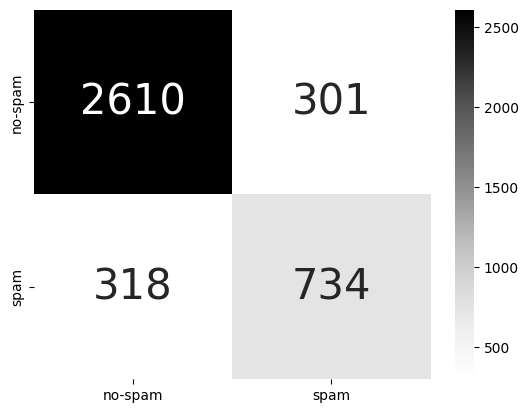

In [46]:
import os
import torch

model_name = "TextCNN_BasisCustLinear"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(1).pth"
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=1)

In [47]:
import os
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(1).csv'), index=False)
wrong_df = predict_df[predict_df.label != predict_df.predict]
sorted_df = wrong_df.sort_values(['label', 'predict'], ascending=[False, False])
sorted_df

,comment,category,description,label,predict
7,"Giao hàng siêu siêu siêu nhanh, ko ngờ luôn.\r...",Phương Tiện,Tấm chắn che nắng Ô TÔ Xe Hơi - Phụ ...,1,0
8,Kakaa ba nằm bên trái thì e bé nhét qua bên tr...,Thời Trang,"Quần lót nam thun lạnh nhật bản, quần sịp đúc ...",1,0
25,"Hàng đẹp . giao rất ok , ủng hộ ạ \r\nHàng đẹp...",Sách,Thời gian giao hàng dự kiến cho sản phẩm này l...,1,0
29,"giao hàng rất nhanh, gói hàng cẩn thận. Cảm ơn...",Sắc Đẹp,Miếng dán trắng răng Crest 3D White tẩy trắng ...,1,0
34,Giao hàng nhanh. Hình ảnh vs video mang tính c...,Nhà Cửa - Đời Sống,5 lưu ý trước khi đặt hàng: 1 - Miễn phí vận c...,1,0
...,...,...,...,...,...
3918,Giao hàng nhanh đã nhận được hàng. Khá vừa ý. ...,Thể Thao,THÔNG TIN SẢN PHẨM - Sản phẩm: Tất cổ ngắn - C...,0,1
3925,san pham tot.dung nhu hinh,Điện Tử,Áo vệ sinh máy lạnh có miệng áo có t...,0,1
3940,"Trước giờ toàn ăn vị cay, nay mua thử lẩu thập...",Khác,🌶️Gia Vị Lẩu Haidilao (Hải Đế Lao) Chắc hẳn ai...,0,1
3945,Hàng tới h là ngon,Điện Thoai - Máy Tính,Màn hình Liquid Retina iPad Air mới sở h...,0,1


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8244
Precision: 0.6513
Recall: 0.6781
F1-score: 0.6596
Confusion matrix:
 [[2583   24  200  104]
 [  20   29    2    3]
 [ 109    1  189   10]
 [ 182    8   33  466]]
              precision    recall  f1-score   support

           0     0.8925    0.8873    0.8899      2911
           1     0.4677    0.5370    0.5000        54
           2     0.4458    0.6117    0.5157       309
           3     0.7993    0.6763    0.7327       689

    accuracy                         0.8244      3963
   macro avg     0.6513    0.6781    0.6596      3963
weighted avg     0.8357    0.8244    0.8281      3963



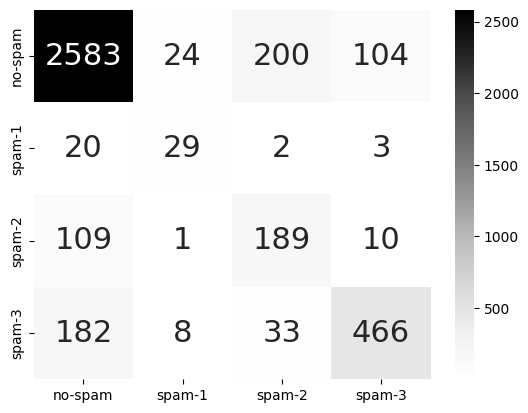

In [48]:
import os
import torch

model_name = "TextCNN_BasisCustLinear"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(2).pth"
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=2)

In [49]:
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'spam_label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(2).csv'), index=False)
wrong_df = predict_df[predict_df.spam_label != predict_df.predict]
sorted_df = wrong_df.sort_values(['spam_label', 'predict'], ascending=[False, False])
sorted_df

,comment,category,description,spam_label,predict
285,"Giao chậm nhg nhanh như cơn gió, ship uy tín n...",Khác,"HƯỚNG DẪN MUA THẺ Viettel 100k ,QUÝ KHÁCH VUI ...",3,2
536,"Giao hàng hơi lâu, đóng gói được, nói chung cũ...",Nhà Cửa - Đời Sống,Sản phẩm khăn giấy ướt được sản xuất từ nguyên...,3,2
586,"shop giao hàng nhanh, chu đáo, cẩn thận rất hà...",Đồ Chơi,"Máy Tạo Tiếng Ồn Trắng Giúp bé ngủ ngon, sâu g...",3,2
628,"Giao hàng nhanh chóng,bbdbfbfjfjhfbfhfhhfjfhfh...",Nhà Cửa - Đời Sống,"Cam kết: - Hàng chuẩn công ty, dày đẹp - Không...",3,2
700,Cảm ơn b đã tin tưởng và ủng hộ kín...,Khác,[E-voucher] Mã mua hàng Shopee (trừ Nạp Thẻ...,3,2
...,...,...,...,...,...
2415,Đóng gói sản phẩm tuyệt vời!!!\r\nHàng kích th...,Thời Trang,ĐẶC ĐIỂM NỔI BẬT: – Được làm từ chất liệu nhựa...,0,1
2599,Mua được giảm giá sản phẩm tốt,Khác,Cà Phê Rang Xay Moka Highlands Coffee (200g)...,0,1
2732,Chất lượng sản phẩm tuyệt vời. Đóng gói sản ph...,Thời Trang,Túi Zip Đựng Đồ Trong Suốt Nhiều Size Hoạ Tiết...,0,1
3829,Giao hàng nhanh balo đỉnh luôn với giá thế này...,Thời Trang,"Balo Laptop nam nữ Thời Trang chống trộm, chốn...",0,1


In [50]:
import numpy as np
import torch
import torch.nn.functional as F

class_names = ['no-spam', 'spam']
spam_class_names = ['no-spam', 'spam-1', 'spam-2', 'spam-3']

def encode_text(text, word2idx, max_len=100):
    tokenized_text = word_tokenize(text)
    if len(tokenized_text) > max_len:
        tokenized_text = tokenized_text[:max_len]
    tokenized_text += ['<pad>'] * (max_len - len(tokenized_text))
    input_id = [word2idx.get(token, word2idx['<unk>']) for token in tokenized_text]
    return np.array(input_id)

def inference(model, text, category, word2idx, category2idx, task=1): 
    model.eval()
    
    input_ids = encode_text(text, word2idx, max_len=100)
    input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)
    category_id = torch.tensor(category2idx[category]).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(input_ids, category_id)
    predict_label = torch.argmax(outputs, dim=1)[0]
    probability = F.softmax(outputs, dim=1)[0][predict_label]
    
    print(f'Comment: {text}')
    print(f'Category: {category}')
    print(f'Predict: {class_names[predict_label] if task == 1 else spam_class_names[predict_label]}')
    print(f'Probability: {round(probability.cpu().item(), 4)}')

In [51]:
category2idx = {
    'Điện Thoai - Máy Tính': 0,
    'Khác': 1,
    'Máy Ảnh': 2,
    'Nhà Cửa - Đời Sống': 3,
    'Điện Tử': 4,
    'Thời Trang': 5,
    'Sắc Đẹp': 6,
    'Sách': 7,
    'Phương Tiện': 8,
    'Giày Dép': 9, 
    'Thể Thao': 10,
    'Đồ Chơi': 11,
}

task = 2
model_name = "TextCNN_BasisCustLinear"
model = ViSpam_Classifier(model_name, task=2).to(device)
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_({task}).pth"
model.load_state_dict(torch.load(model_path))

comment = 'điện thoại nokia thì không phải bàn rồi'
category = 'Điện Thoai - Máy Tính'
inference(model, comment, category, word2idx, category2idx, task)

Loaded pretrained embeddings, weights are not trainable.
Comment: điện thoại nokia thì không phải bàn rồi
Category: Điện Thoai - Máy Tính
Predict: no-spam
Probability: 0.6923


# PhoBERT + SPhoBert

In [52]:
import sys

sys.path.append("../input/sentence-transformers")

In [53]:
from torch import nn
from transformers import AutoModel, BertModel

class ViSpam_Classifier(nn.Module):
    def __init__(self, model_name, task, freeze_bert=False, drop=0.3):
        super(ViSpam_Classifier, self).__init__()
        
        assert model_name in ['PhoBERT_SPhoBert', 'BERT4News_SBert4News', 'ViBERT_Description']
        
        self.model_name = model_name
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.desc_size = 768
        
        if 'PhoBERT' in model_name:
            self.bert = AutoModel.from_pretrained('vinai/phobert-base')
        else:
            self.bert = BertModel.from_pretrained('NlpHUST/vibert4news-base-cased')
            
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
        self.drop = nn.Dropout(drop)
        self.fc = nn.Linear(self.bert.config.hidden_size + self.desc_size, self.num_classes)
        # nn.init.normal_(self.fc.weight, std=0.02)
        # nn.init.normal_(self.fc.bias, 0)
        
    def forward(self, input_ids, attention_mask, description):
        last_hidden_state, output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        conc = torch.cat((output, description), 1)
        x = self.drop(conc)
        x = self.fc(x)
        return x
    

def test(model, dataloader, task):
    model.eval()
    predicts = []
    predict_probs = []
    true_labels = []
    
    label_column = 'label' if task == 1 else 'spam_label'

    for data in tqdm(dataloader):
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        description = data[f'encoded_description_{task}'].to(device)
        labels = data[label_column].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, description=description)
            
        pred = torch.max(outputs, dim=1)[1]
        predicts.extend(pred.cpu().data.numpy())
        predict_probs.extend(outputs.cpu().data.numpy())
        true_labels.extend(labels.cpu().data.numpy())
        
    return true_labels, predicts

In [54]:
from sentence_transformers import SentenceTransformer

model_dir = '../input/vispamreviews-models/PhoBERT_SPhoBert/SPhoBert/'
model_name = "vinai-phobert-base"
sentence_model_1 = SentenceTransformer(model_dir + f'training_nli_{model_name}-task-1-tokenized', device=device)
sentence_model_2 = SentenceTransformer(model_dir + f'training_nli_{model_name}-task-2-tokenized', device=device)

def encode_description(example):
    embeddings_1 = sentence_model_1.encode(example['clean_description'], show_progress_bar=False)
    embeddings_2 = sentence_model_2.encode(example['clean_description'], show_progress_bar=False)
    return {'encoded_description_1': embeddings_1, 'encoded_description_2': embeddings_2}

encoded_datasets = vispam_datasets.map(encode_description, batched=True)

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [55]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

def encode_comment(examples):
    return tokenizer(examples["clean_tokenized_comment"], padding="max_length", max_length=100, truncation=True, add_special_tokens=True)

encoded_datasets = encoded_datasets.map(encode_comment, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-4])
encoded_datasets.set_format("torch")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [56]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=256)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=256)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=256)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.9011
Precision: 0.8751
Recall: 0.8695
F1-score: 0.8722
Confusion matrix:
 [[2727  184]
 [ 208  844]]
              precision    recall  f1-score   support

           0     0.9291    0.9368    0.9329      2911
           1     0.8210    0.8023    0.8115      1052

    accuracy                         0.9011      3963
   macro avg     0.8751    0.8695    0.8722      3963
weighted avg     0.9004    0.9011    0.9007      3963



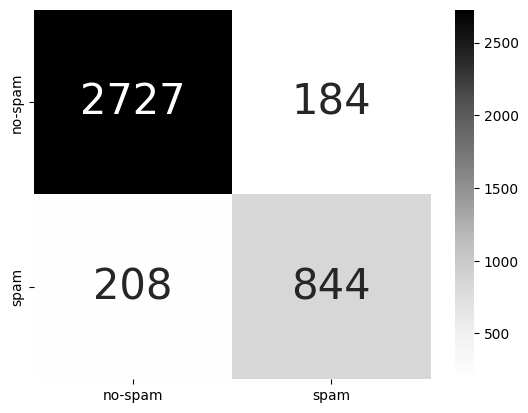

In [57]:
import os
import torch

model_name = "PhoBERT_SPhoBert"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(1).pth"
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=1)

In [58]:
import os
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(1).csv'), index=False)
wrong_df = predict_df[predict_df.label != predict_df.predict]
sorted_df = wrong_df.sort_values(['label', 'predict'], ascending=[False, False])
sorted_df

,comment,category,description,label,predict
25,"Hàng đẹp . giao rất ok , ủng hộ ạ \r\nHàng đẹp...",Sách,Thời gian giao hàng dự kiến cho sản phẩm này l...,1,0
38,Mua bnh cái túi đựng bài cũng k bao h là đủ ấy...,Nhà Cửa - Đời Sống,Túi Nhung Đưng Tarot Tiền Cao Cấp Túi vải nhun...,1,0
44,Không chụp ảnh được sản phẩm nên mình lấy tạm ...,Máy Ảnh,Đặc tính ưu Việt của Camera Yoosee Tiếng Việt ...,1,0
53,hàng OK rồi em vẫn đang tiếp tục vào vai một c...,Khác,Dầu Ăn Thượng Hạng Nhãn Hiệu Neptune...,1,0
60,"Giao nhanh của Tiki Now. Hàng ok, để lắp vào x...",Điện Thoai - Máy Tính,Tốc độ cực cao RAM Laptop Samsung 8GB DD...,1,0
...,...,...,...,...,...
3840,Dây y hình\r\nĐóng gói cẢn thận\r\nSẽ ủng hộ s...,Thể Thao,👉SPORT 247 cam kết giá bán rẻ nhất shopee ở đâ...,0,1
3896,Tạm thời là dùng ổn,Điện Tử,Thiết kế thân thiện Logitech B100 sử ...,0,1
3913,Siêu tooooo\r\nGiao hàng siêu nhanh\r\nHàng sử...,Điện Tử,GIAO HÀNG VÀ LẮP ĐẶT CÙNG LÚCGiá sản...,0,1
3938,"Giao hàng nhanh, viên nén xinh. Giao hàng nhan...",Nhà Cửa - Đời Sống,"Mô tả sản phẩm: - Mùa hè, mùa du lịch, mùa dã ...",0,1


Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8806
Precision: 0.7492
Recall: 0.7241
F1-score: 0.7349
Confusion matrix:
 [[2710   11  139   51]
 [  17   30    1    6]
 [ 120    1  180    8]
 [  92    4   23  570]]
              precision    recall  f1-score   support

           0     0.9221    0.9310    0.9265      2911
           1     0.6522    0.5556    0.6000        54
           2     0.5248    0.5825    0.5521       309
           3     0.8976    0.8273    0.8610       689

    accuracy                         0.8806      3963
   macro avg     0.7492    0.7241    0.7349      3963
weighted avg     0.8832    0.8806    0.8815      3963



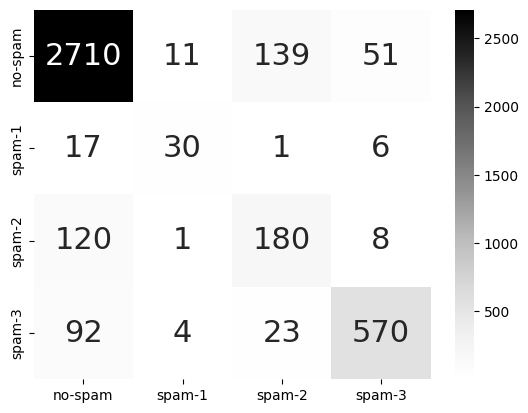

In [59]:
import os
import torch

model_name = "PhoBERT_SPhoBert"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(2).pth"
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=2)

In [60]:
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'spam_label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(2).csv'), index=False)
wrong_df = predict_df[predict_df.spam_label != predict_df.predict]
sorted_df = wrong_df.sort_values(['spam_label', 'predict'], ascending=[False, False])
sorted_df

,comment,category,description,spam_label,predict
59,Hàng ạ gởi bài vào vào đây ạ gửi gửi vào túi n...,Thời Trang,Thời gian giao hàng dự kiến cho sản phẩm này l...,3,2
766,giao hàng,Khác,LƯU Ý: Bao Bì Sản phẩm có thể thay đo...,3,2
805,Shop kết nối sao vậy shop,Máy Ảnh,"* Sản phẩm có 3 thuộc tính lựa chọn,...",3,2
887,Khách Sỉ đặt em lô hàng lớn mà giờ chỗ khách b...,Nhà Cửa - Đời Sống,Thời gian giao hàng dự kiến cho sản phẩm này ...,3,2
1005,Đặt 8 cửa shop giao có 5 cửa nt shop k phản hồ...,Thể Thao,Giới thiệu sản phẩm Lưới bát quái đánh bắt cá ...,3,2
...,...,...,...,...,...
1827,"Chất lượng sản phẩm tuyệt vời, giao hàng nhanh...",Điện Thoai - Máy Tính,Lót chuột cỡ lớn 80x30cm chuyên game chống trơ...,0,1
2732,Chất lượng sản phẩm tuyệt vời. Đóng gói sản ph...,Thời Trang,Túi Zip Đựng Đồ Trong Suốt Nhiều Size Hoạ Tiết...,0,1
2826,"Chất lượng sản phẩm tuyệt vời , giao hàng nhan...",Phương Tiện,Chất Liệu : Titan Đặc Tính : Là Hợp Kim Cứng H...,0,1
2909,"Chất lượng sản phẩm tuyệt vời, má",Điện Tử,"Thiết kế hiện đại, tinh tế Máy lạnh...",0,1


In [61]:
import torch
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer

def inference(model, comment, description, tokenizer, task=1):
    model.eval()
    
    # Comment
    tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
    data = tokenizer(comment, padding="max_length", max_length=100, truncation=True, add_special_tokens=True)
    input_ids = torch.tensor(data['input_ids']).unsqueeze(0).to(device)
    attention_mask = torch.tensor(data['attention_mask']).unsqueeze(0).to(device)
    
    # Description
    model_dir = '../input/vispamreviews-models/PhoBERT_SPhoBert/SPhoBert/'
    model_name = "vinai-phobert-base"
    sentence_model = SentenceTransformer(model_dir + f'training_nli_{model_name}-task-{task}-tokenized', device=device)
    encoded_description = sentence_model.encode(description, show_progress_bar=False)
    encoded_description = torch.tensor(encoded_description).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask, encoded_description)
    predict_label = torch.argmax(outputs, dim=1)[0]
    probability = F.softmax(outputs, dim=1)[0][predict_label]
    
    print(f'Comment: {comment}')
    print(f'Description: {description}')
    print(f'Predict: {class_names[predict_label] if task == 1 else spam_class_names[predict_label]}')
    print(f'Probability: {round(probability.cpu().item(), 4)}')

In [62]:
task = 2
model_name = "PhoBERT_SPhoBert"
model = ViSpam_Classifier(model_name, task).to(device)
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_({task}).pth"
model.load_state_dict(torch.load(model_path))

comment = 'nói chung là hàng mới nhận thôi, mình chưa biết dùng có tốt không nữa, lần sau sẽ đánh giá'
description = "giày đẹp phù hợp với mọi người"
inference(model, comment, description, tokenizer, task)

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Comment: nói chung là hàng mới nhận thôi, mình chưa biết dùng có tốt không nữa, lần sau sẽ đánh giá
Description: giày đẹp phù hợp với mọi người
Predict: no-spam
Probability: 0.9597


# BiLSTM - BasisCustLinear + SBert4News

In [63]:
class TextCNN(nn.Module):
    def __init__(self, embedding_dim, kernel_sizes=[2, 3, 5], num_filters=32):
        super(TextCNN, self).__init__()
        
        self.conv = nn.ModuleList([nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=k, stride=1) for k in kernel_sizes])
        
    def forward(self, h_embedding, description):
        x = h_embedding.permute(0, 2, 1)
        x = [F.relu(conv(x)) for conv in self.conv]
        x = [F.max_pool1d(c, kernel_size=c.shape[2]).squeeze(dim=2) for c in x]
        x = torch.cat(x, dim=1)
        desc_conc = torch.cat((x, description), dim=1)
        return desc_conc
        
        
class BiLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_size):
        super(BiLSTM, self).__init__()
        
        self.lstm = nn.LSTM(embedding_dim, hidden_size, bidirectional=True, batch_first=True)
    
    def forward(self, h_embedding, description):
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat((avg_pool, max_pool), dim=1)
        desc_conc = torch.cat((conc, description), dim=1)
        return desc_conc
        
        
class BiGRU(nn.Module):
    def __init__(self, embedding_dim, hidden_size):
        super(BiGRU, self).__init__()
        
        self.gru = nn.GRU(embedding_dim, hidden_size, bidirectional=True, batch_first=True)
    
    def forward(self, h_embedding, description):
        h_gru, _ = self.gru(h_embedding)
        avg_pool = torch.mean(h_gru, 1)
        max_pool, _ = torch.max(h_gru, 1)
        conc = torch.cat((avg_pool, max_pool), dim=1)
        desc_conc = torch.cat((conc, description), dim=1)
        return desc_conc

In [64]:
import torch
from torch import nn

class ViSpam_Classifier(nn.Module):
    def __init__(self, model_name, task, kernel_sizes=[2, 3, 5], num_filters=32, hidden_size=64, drop=0.5, spatial_dropout=True, mode='static'):
        super(ViSpam_Classifier, self).__init__()
        
        self.model_name = model_name
        name, model_type, _ = model_name.split('_')
        
        assert name in ['TextCNN', 'BiLSTM', 'BiGRU']
        assert model_type in ['CustBias', 'CustLinear', 'CustWordEmbedding', 'BasisCustBias', 'BasisCustLinear', 'BasisCustWordEmbedding']
        
        self.task = task
        self.num_classes = 2 if task == 1 else 4
        self.vocab_size, self.embedding_dim = embeddings.shape
        self.kernel_sizes = kernel_sizes
        self.num_filters = num_filters
        self.hidden_size = hidden_size
        self.drop = drop
        self.spatial_dropout = spatial_dropout
        self.mode = mode
        
        self.meta_dim = 64
        self.key_query_size = 64
        self.num_bases = 4
        
        self.meta_param_manager = MetaParamManager()
        self.meta_units = [('category_id', num_categories)]\
        
        self.desc_size = 768
        
        # Word embedding
        if model_type == 'CustWordEmbedding':
            self.embedding = CustWordEmbedding(
                vocab_size=self.vocab_size,
                embedding_dim=self.embedding_dim,
                meta_units=self.meta_units,
                meta_param_manager=self.meta_param_manager
            )
        elif model_type == 'BasisCustWordEmbedding':
            self.embedding = BasisCustWordEmbedding(
                vocab_size=self.vocab_size,
                embedding_dim=self.embedding_dim,
                meta_units=self.meta_units,
                meta_dim=self.meta_dim,
                key_query_size=self.key_query_size,
                num_bases=self.num_bases,
                meta_param_manager=self.meta_param_manager
            )
        else:
            self.embedding = BasicWordEmbedding(vocab_size=self.vocab_size, embedding_dim=self.embedding_dim)
            
        self.embedding.load_embeddings(mode)
        
        # Spatial dropout
        if spatial_dropout:
            self.spatial_dropout1d = nn.Dropout2d(drop)
        else:
            self.dropout = nn.Dropout(drop)
        
        # Model
        if name == 'TextCNN':
            self.network = TextCNN(self.embedding_dim, kernel_sizes, num_filters)
            self.state_size = len(kernel_sizes)*num_filters
        elif name == 'BiLSTM':
            self.network = BiLSTM(self.embedding_dim, hidden_size)
            self.state_size = hidden_size*4
        else:
            self.network = BiGRU(self.embedding_dim, hidden_size)
            self.state_size = hidden_size*4
            
        self.state_size += self.desc_size
        
        # Linear
        if model_type == 'CustLinear':
            self.W = CustLinear(
                meta_units=self.meta_units,
                state_size=self.state_size,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        elif model_type == 'BasisCustLinear':
            self.W = BasisCustLinear(
                meta_units=self.meta_units,
                meta_dim=self.meta_dim,
                key_query_size=self.key_query_size,
                state_size=self.state_size,
                num_bases=self.num_bases,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        else:
            self.W = BasicLinear(state_size=self.state_size, num_classes=self.num_classes)
            
        # Bias
        if model_type == 'CustBias':
            self.bias = CustBias(
                meta_units=self.meta_units,
                state_size=self.state_size,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        elif model_type == 'BasisCustBias':
            self.bias = BasisCustBias(
                meta_units=self.meta_units,
                meta_dim=self.meta_dim,
                state_size=self.state_size,
                key_query_size=self.key_query_size,
                num_bases=self.num_bases,
                num_classes=self.num_classes,
                meta_param_manager=self.meta_param_manager
            )
        else:
            self.bias = BasicBias(self.num_classes)
            
    def forward(self, input_ids, category_id, description):
        batch_size, sequence_length = input_ids.shape
        
        if 'CustWordEmbedding' in self.model_name:
            h_embedding = self.embedding(input_ids, category_id)
        else:
            h_embedding = self.embedding(input_ids)
        
        if self.spatial_dropout:
            h_embedding = h_embedding.permute(0, 2, 1)
            h_embedding = self.spatial_dropout1d(h_embedding)
            h_embedding = h_embedding.permute(0, 2, 1)
        else:
            h_embedding = self.dropout(h_embedding)
        
        output_net = self.network(h_embedding, description)
        
        if 'CustLinear' in self.model_name:
            x = self.W(output_net, category_id)
        else:
            x = self.W(output_net)
        
        if 'CustBias' in self.model_name:
            x += self.bias(category_id)
        else:
            x += self.bias()
        
        return x
    

def test(model, dataloader, task):
    model.eval()
    predicts = []
    predict_probs = []
    true_labels = []
    
    label_column = 'label' if task == 1 else 'spam_label'
    
    for data in tqdm(dataloader):
        input_ids = data['input_id'].to(device)
        category_id = data['category_id'].to(device)
        description = data[f'encoded_description_{task}'].to(device)
        labels = data[label_column].to(device)

        with torch.no_grad():
            outputs = model(input_ids, category_id, description)
  
        pred = torch.max(outputs, dim=1)[1]
        predicts.extend(pred.cpu().data.numpy())
        predict_probs.extend(outputs.cpu().data.numpy())
        true_labels.extend(labels.cpu().data.numpy())
        
    return true_labels, predicts

In [65]:
category2idx = {
    'Thời Trang': 0,
    'Sách': 1,
    'Điện Thoai - Máy Tính': 2,
    'Đồ Chơi': 3,
    'Sắc Đẹp': 4,
    'Thể Thao': 5,
    'Nhà Cửa - Đời Sống': 6,
    'Khác': 7,
    'Phương Tiện': 8, 
    'Máy Ảnh': 9,
    'Giày Dép': 10,
    'Điện Tử': 11,
} 
num_categories = len(category2idx)
print("Number of categories:", num_categories)

Number of categories: 12


In [66]:
from sentence_transformers import SentenceTransformer

model_dir = "../input/vispamreviews-models/BiLSTM_BasisCustLinear_SBert4News/SBert4News/"
model_name = "NlpHUST-vibert4news-base-cased"

sentence_model_1 = SentenceTransformer(model_dir + f"training_nli_{model_name}-task-1", device=device)
sentence_model_2 = SentenceTransformer(model_dir + f"training_nli_{model_name}-task-2", device=device)

def encode_description(example):
    embeddings_1 = sentence_model_1.encode(example['clean_description'], show_progress_bar=False)
    embeddings_2 = sentence_model_2.encode(example['clean_description'], show_progress_bar=False)
    return {'encoded_description_1': embeddings_1, 'encoded_description_2': embeddings_2}

vispam_datasets = vispam_datasets.map(encode_description, batched=True)

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [67]:
def encode_mapping(examples):
    tokenized_texts = [word_tokenize(sent) for sent in examples['clean_comment']]
    input_ids = encoding(tokenized_texts, word2idx, max_len=100)
    category_ids = [category2idx[category] for category in examples['category']]
    
    return {'input_id': input_ids, "category_id": category_ids}


encoded_datasets = vispam_datasets.map(encode_mapping, batched=True)
encoded_datasets = encoded_datasets.remove_columns(vispam_datasets['train'].column_names[:-4])
encoded_datasets.set_format("torch")

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [68]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(encoded_datasets['train'], shuffle=True, batch_size=256)
val_dataloader = DataLoader(encoded_datasets['dev'], batch_size=256)
test_dataloader = DataLoader(encoded_datasets['test'], batch_size=256)

Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8451
Precision: 0.8001
Recall: 0.8089
F1-score: 0.8043
Confusion matrix:
 [[2579  332]
 [ 282  770]]
              precision    recall  f1-score   support

           0     0.9014    0.8859    0.8936      2911
           1     0.6987    0.7319    0.7149      1052

    accuracy                         0.8451      3963
   macro avg     0.8001    0.8089    0.8043      3963
weighted avg     0.8476    0.8451    0.8462      3963



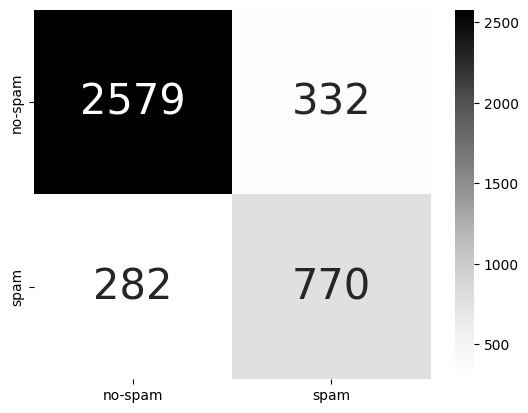

In [69]:
import os
import torch

model_name = "BiLSTM_BasisCustLinear_SBert4News"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(1).pth"
model = ViSpam_Classifier(model_name, task=1).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=1)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=1)

In [70]:
import os
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(1).csv'), index=False)
wrong_df = predict_df[predict_df.label != predict_df.predict]
sorted_df = wrong_df.sort_values(['label', 'predict'], ascending=[False, False])
sorted_df

,comment,category,description,label,predict
7,"Giao hàng siêu siêu siêu nhanh, ko ngờ luôn.\r...",Phương Tiện,Tấm chắn che nắng Ô TÔ Xe Hơi - Phụ ...,1,0
8,Kakaa ba nằm bên trái thì e bé nhét qua bên tr...,Thời Trang,"Quần lót nam thun lạnh nhật bản, quần sịp đúc ...",1,0
25,"Hàng đẹp . giao rất ok , ủng hộ ạ \r\nHàng đẹp...",Sách,Thời gian giao hàng dự kiến cho sản phẩm này l...,1,0
34,Giao hàng nhanh. Hình ảnh vs video mang tính c...,Nhà Cửa - Đời Sống,5 lưu ý trước khi đặt hàng: 1 - Miễn phí vận c...,1,0
38,Mua bnh cái túi đựng bài cũng k bao h là đủ ấy...,Nhà Cửa - Đời Sống,Túi Nhung Đưng Tarot Tiền Cao Cấp Túi vải nhun...,1,0
...,...,...,...,...,...
3918,Giao hàng nhanh đã nhận được hàng. Khá vừa ý. ...,Thể Thao,THÔNG TIN SẢN PHẨM - Sản phẩm: Tất cổ ngắn - C...,0,1
3925,san pham tot.dung nhu hinh,Điện Tử,Áo vệ sinh máy lạnh có miệng áo có t...,0,1
3938,"Giao hàng nhanh, viên nén xinh. Giao hàng nhan...",Nhà Cửa - Đời Sống,"Mô tả sản phẩm: - Mùa hè, mùa du lịch, mùa dã ...",0,1
3943,quay lại mua lần thứ 4 .cứ mỗi lần lại ...,Nhà Cửa - Đời Sống,Ngủ ngon và sâu hơn với sự nâng đỡ ...,0,1


Loaded pretrained embeddings, weights are not trainable.


  0%|          | 0/16 [00:00<?, ?it/s]

Accuracy: 0.8082
Precision: 0.6023
Recall: 0.7059
F1-score: 0.6364
Confusion matrix:
 [[2478   42  257  134]
 [  12   33    5    4]
 [  88    5  200   16]
 [ 145   19   33  492]]
              precision    recall  f1-score   support

           0     0.9100    0.8513    0.8797      2911
           1     0.3333    0.6111    0.4314        54
           2     0.4040    0.6472    0.4975       309
           3     0.7616    0.7141    0.7371       689

    accuracy                         0.8082      3963
   macro avg     0.6023    0.7059    0.6364      3963
weighted avg     0.8369    0.8082    0.8190      3963



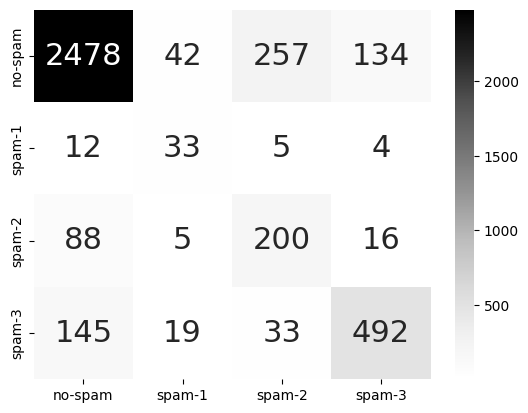

In [71]:
import os
import torch

model_name = "BiLSTM_BasisCustLinear_SBert4News"
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_(2).pth"
model = ViSpam_Classifier(model_name, task=2).to(device)
model.load_state_dict(torch.load(model_path))
true_labels, predicts = test(model, test_dataloader, task=2)
test_cm = evaluate(true_labels, predicts)
plotting_confusion_matrix(test_cm, model_name, task=2)

In [72]:
import pandas as pd

predict_df = pd.DataFrame({'comment': vispam_datasets['test']['comment'],
                           'category': vispam_datasets['test']['category'],
                           'description': vispam_datasets['test']['description'],
                           'spam_label': true_labels, 'predict': predicts})
predict_df.to_csv(os.path.join(model_name, f'{model_name}_test_prediction_(2).csv'), index=False)
wrong_df = predict_df[predict_df.spam_label != predict_df.predict]
sorted_df = wrong_df.sort_values(['spam_label', 'predict'], ascending=[False, False])
sorted_df

,comment,category,description,spam_label,predict
59,Hàng ạ gởi bài vào vào đây ạ gửi gửi vào túi n...,Thời Trang,Thời gian giao hàng dự kiến cho sản phẩm này l...,3,2
347,"Đồng hồ siuu đẹp hợp với giá tiền, đóng gói hà...",Thời Trang,Mô tả sản phẩm: Pin cúc áo được sử dụng phổ bi...,3,2
536,"Giao hàng hơi lâu, đóng gói được, nói chung cũ...",Nhà Cửa - Đời Sống,Sản phẩm khăn giấy ướt được sản xuất từ nguyên...,3,2
586,"shop giao hàng nhanh, chu đáo, cẩn thận rất hà...",Đồ Chơi,"Máy Tạo Tiếng Ồn Trắng Giúp bé ngủ ngon, sâu g...",3,2
628,"Giao hàng nhanh chóng,bbdbfbfjfjhfbfhfhhfjfhfh...",Nhà Cửa - Đời Sống,"Cam kết: - Hàng chuẩn công ty, dày đẹp - Không...",3,2
...,...,...,...,...,...
3199,Hàng rẻ mà chất lượng nha mn nên mua ạ hihi mu...,Máy Ảnh,"⚠Cam kết hàng chất lượng ,hoàn tiền khi khách ...",0,1
3615,Khăn đẹp. 😉 Nếu hay mua hàng online giống mình...,Nhà Cửa - Đời Sống,GOOO STORE CAM KẾT Đổi trả và hoàn tiền 100% n...,0,1
3734,Lần thứ 2 mua lại sản phẩm này.\r\nThú thật m...,Sắc Đẹp,Tinh chất chống nắng hiệu chỉnh sắc...,0,1
3799,Chưa bh mua ở đâu được váy giá này và chất lượ...,Thời Trang,SUTANO Kính chào quý khách - Chúc quý khách mu...,0,1


In [73]:
import torch
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer

class_names = ['no-spam', 'spam']
spam_class_names = ['no-spam', 'spam-1', 'spam-2', 'spam-3']

def encode_text(text, word2idx, max_len=100):
    tokenized_text = word_tokenize(text)
    if len(tokenized_text) > max_len:
        tokenized_text = tokenized_text[:max_len]
    tokenized_text += ['<pad>'] * (max_len - len(tokenized_text))
    input_id = [word2idx.get(token, word2idx['<unk>']) for token in tokenized_text]
    return np.array(input_id)


def inference(model, comment, description, category, word2idx, task=1):
    if category not in category2idx:
        return
    
    model.eval()
    
    # Comment
    input_ids = encode_text(comment, word2idx, max_len=100)
    input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)    
    
    # Description
    model_dir = "../input/vispamreviews-models/BiLSTM_BasisCustLinear_SBert4News/SBert4News/"
    model_name = "NlpHUST-vibert4news-base-cased"
    sentence_model = SentenceTransformer(model_dir + f'training_nli_{model_name}-task-{task}', device=device)
    encoded_description = sentence_model.encode(description, show_progress_bar=False)
    encoded_description = torch.tensor(encoded_description).unsqueeze(0).to(device)
    
    # Category
    category_id = torch.tensor(category2idx[category]).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(input_ids, category_id, encoded_description)
    predict_label = torch.argmax(outputs, dim=1)[0]
    probability = F.softmax(outputs, dim=1)[0][predict_label]
    
    print(f'Comment: {comment}')
    print(f'Description: {description}')
    print(f'Category: {category}')
    print(f'Predict: {class_names[predict_label] if task == 1 else spam_class_names[predict_label]}')
    print(f'Probability: {round(probability.cpu().item(), 4)}')

In [74]:
category2idx = {
    'Thời Trang': 0,
    'Sách': 1,
    'Điện Thoai - Máy Tính': 2,
    'Đồ Chơi': 3,
    'Sắc Đẹp': 4,
    'Thể Thao': 5,
    'Nhà Cửa - Đời Sống': 6,
    'Khác': 7,
    'Phương Tiện': 8, 
    'Máy Ảnh': 9,
    'Giày Dép': 10,
    'Điện Tử': 11,
}

task = 2
model_name = "BiLSTM_BasisCustLinear_SBert4News"
model = ViSpam_Classifier(model_name, task).to(device)
model_path = f"../input/vispamreviews-models/{model_name}/{model_name}_({task}).pth"
model.load_state_dict(torch.load(model_path))

comment = 'điện thoại này dùng tốt, mọi người nên mua nha'
description = "điện thoại này phù hợp với mọi người, sỡ hữu kích thước màn hình lớn, dung lượng cao"
category = 'Điện Thoai - Máy Tính'
inference(model, comment, description, category, word2idx, task)

Loaded pretrained embeddings, weights are not trainable.
Comment: điện thoại này dùng tốt, mọi người nên mua nha
Description: điện thoại này phù hợp với mọi người, sỡ hữu kích thước màn hình lớn, dung lượng cao
Category: Điện Thoai - Máy Tính
Predict: no-spam
Probability: 0.732
